In [87]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import lemmatize

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim as gensimvis 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from collections import Counter

import nltk
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
nltk.download('punkt')

import random

import seaborn as sns
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kangping\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import Data

In [2]:
reviews = pd.read_csv("Preprocessing_review_df.csv")
reviews.head()

ReviewID      SKU  Star                                            Reviews
0         1  6047800     5  old missed actual photo cranking great quality...
1         2  6047800     5  cheaper buying instax cartridge cent selphy ce...
2         3  6047800     5  wife picture worry noisy employee getting phot...
3         4  6047800     5  east put together perfect size home room nicel...
4         5  6047800     5     product perfect recomendado buenas fotos gusta

# Create words lists 200 data with 5 stars, 200 data with 4 and 3 stars, and all 2 and 1 stars

In [13]:
print('5 stars: '+str(len(reviews[reviews["Star"]==5])))
print('3&4 stars: '+str(len(reviews[(reviews["Star"]==3) | (reviews["Star"]==4)])))
print('1&2 stars: '+str(len(reviews[(reviews["Star"]==1) | (reviews["Star"]==2)])))

5 stars: 536
3&4 stars: 260
1&2 stars: 63


In [14]:
random.seed(10)
reviews_5 = reviews[reviews["Star"]==5].sample(n=150)
reviews_34 = reviews[(reviews["Star"]==3) | (reviews["Star"]==4)].sample(n=150)
reviews_12 = reviews[(reviews["Star"]==1) | (reviews["Star"]==2)]
print("5 star: "+ str(reviews_5.shape)+'\n' + " 3 and 4 star: " + str(reviews_34.shape) +'\n'+ "1 and 2 star: "+ str(reviews_12.shape))

5 star: (150, 4)
 3 and 4 star: (150, 4)
1 and 2 star: (63, 4)


In [15]:
# 5 stars
string_5 = " ".join(review for review in reviews_5["Reviews"])
words_5=string_5.split()
word_freq_5=Counter(words_5)
five_most_common_5=word_freq_5.most_common(20)
five_most_common_5

[('ink', 269),
 ('easy', 140),
 ('app', 132),
 ('photo', 118),
 ('great', 110),
 ('cartridge', 105),
 ('color', 81),
 ('quality', 80),
 ('home', 79),
 ('feature', 76),
 ('work', 70),
 ('setup', 68),
 ('document', 63),
 ('phone', 63),
 ('smart', 59),
 ('device', 56),
 ('tank', 55),
 ('scan', 51),
 ('wifi', 47),
 ('office', 46)]

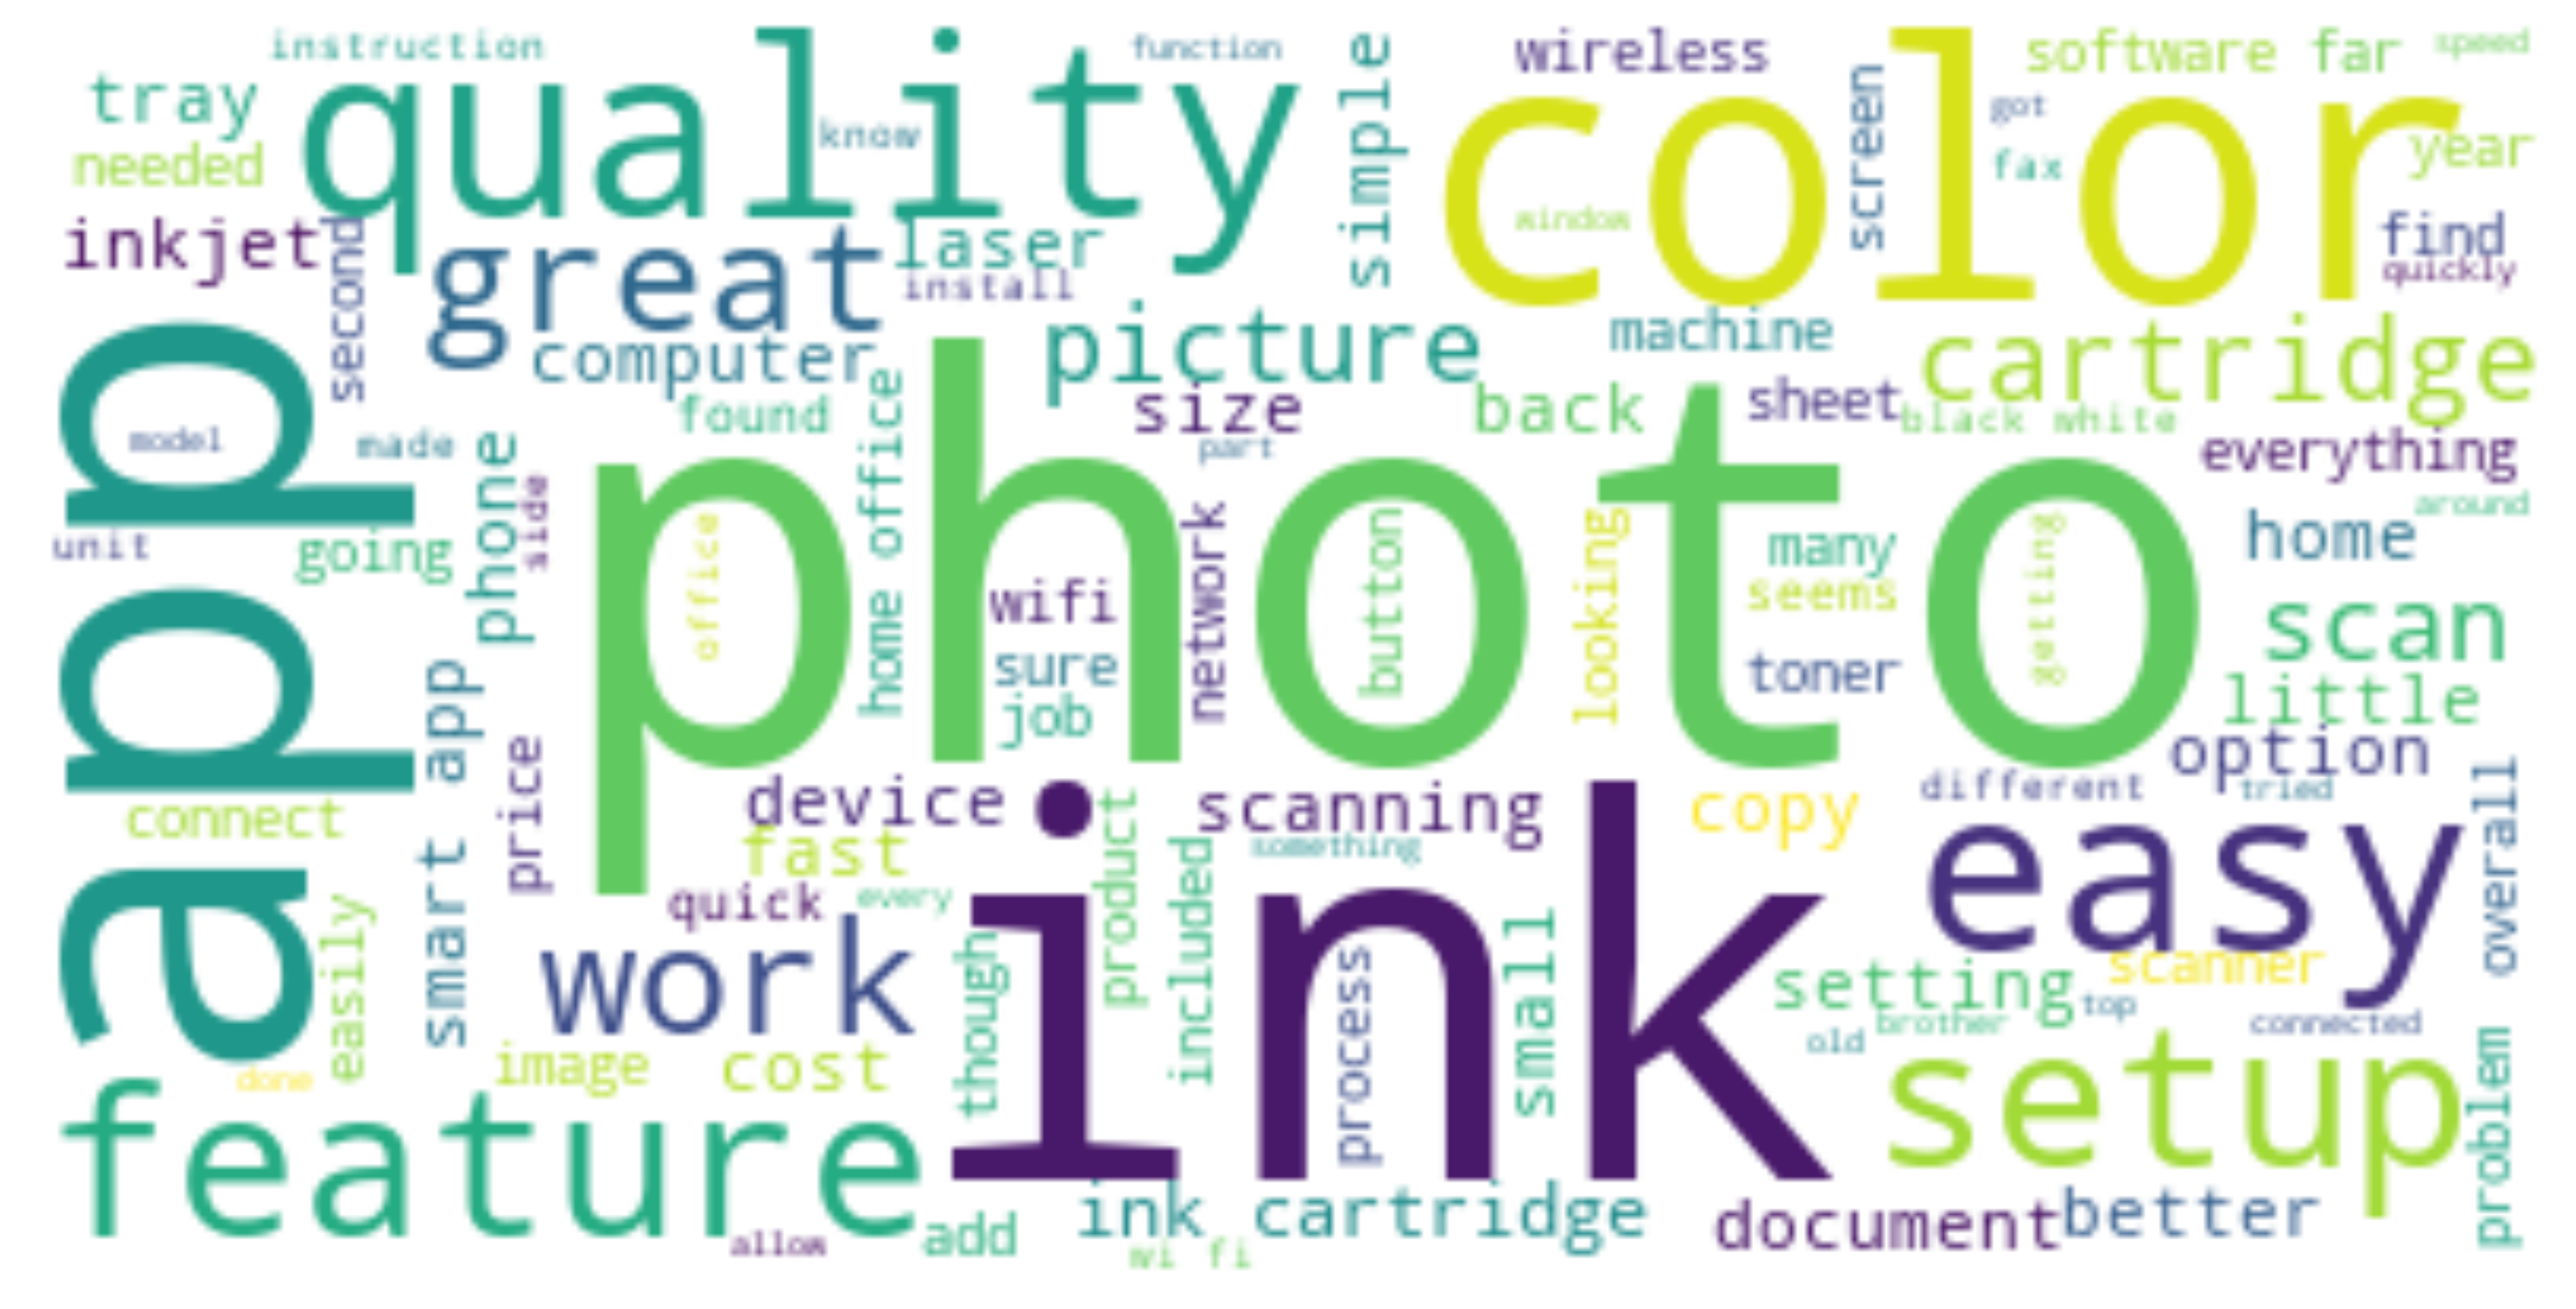

In [16]:
# wordcloud for 5 stars
wordcloud_5 = WordCloud(background_color="white", 
                              max_words=100, 
                             ).generate(string_5)

# view the wordcloud
plt.figure(figsize=(15,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
# Create words list for 5 stars, 3-4 stars, and 1-2 stars
# 5 stars
data_5 = reviews_5.Reviews.values.tolist()
words_5 = [elem.strip().split() for elem in data_5]
# 3-4 stars
data_34 = reviews_34.Reviews.values.tolist()
words_34 = [elem.strip().split() for elem in data_34]
# 1-2 stars
data_12 = reviews_12.Reviews.values.tolist()
words_12 = [elem.strip().split() for elem in data_12]

In [18]:
# Print data_words
print('5 stars:'+'\n'+str(words_5[:1]))
print('3&4 stars:'+'\n'+str(words_34[:1]))
print('1&2 stars:'+'\n'+str(words_12[:1]))

5 stars:
[['product', 'easy', 'friendly', 'simple', 'share', 'friend']]
3&4 stars:
[['ecotank', 'provides', 'basic', 'functionality', 'copy', 'scan', 'looking', 'better', 'value', 'compared', 'cartridge', 'based', 'main', 'draw', 'ecotank', 'line', 'cartridge', 'feature', 'offer', 'convenience', 'cost', 'saving', 'typical', 'ink', 'cartridge', 'system', 'familiar', 'instead', 'wasteful', 'expensive', 'cartridge', 'last', 'hundred', 'designed', 'unique', 'tank', 'system', 'easy', 'fill', 'reasonably', 'priced', 'offer', 'black', 'color', 'far', 'exceeding', 'typical', 'ink', 'cartridge', 'mean', 'le', 'waste', 'included', 'ink', 'completely', 'fill', 'knowing', 'hunting', 'refill', 'anytime', 'soon', 'design', 'basic', 'clean', 'white', 'finish', 'ink', 'front', 'providing', 'visible', 'ink', 'level', 'indicator', 'navigation', 'performed', 'adjustable', 'control', 'panel', 'easy', 'basic', 'copying', 'work', 'expected', 'model', 'includes', 'sheet', 'adf', 'aid', 'dramatically', 'scann

In [48]:
type(words_5)

list

# Creating Bigram and Trigram Models

In [19]:
# Define functions for bigrams, trigrams
def bigram_model(words):
    model=gensim.models.Phrases(words, min_count=5, threshold=100)
    bigram=gensim.models.phrases.Phraser(model)
    return(bigram)

def trigram_model(bigram, words):
    model=gensim.models.Phrases(bigram[words], threshold=100)
    trigram=gensim.models.phrases.Phraser(model)
    return(bigram)    

def make_bigrams(bigram, texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(trigram, texts):
    return [trigram[bigram[doc]] for doc in texts]

# 5 Stars

In [20]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_5 = bigram_model(words_5)
trigram_mod_5 = trigram_model(bigram_mod_5, words_5)

# See trigram example
print(trigram_mod_5[bigram_mod_5[words_5[0]]])

['product', 'easy', 'friendly', 'simple', 'share', 'friend']


In [21]:
# Form Bigrams
data_words_bigrams_5 = make_bigrams(bigram_mod_5,words_5)
print(data_words_bigrams_5[:1])

[['product', 'easy', 'friendly', 'simple', 'share', 'friend']]


# 3&4 Stars

In [22]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_34 = bigram_model(words_34)
trigram_mod_34 = trigram_model(bigram_mod_34,words_34)

# See trigram example
print(trigram_mod_34[bigram_mod_34[words_34[0]]])

['ecotank', 'provides', 'basic', 'functionality', 'copy', 'scan', 'looking', 'better', 'value', 'compared', 'cartridge', 'based', 'main', 'draw', 'ecotank', 'line', 'cartridge', 'feature', 'offer', 'convenience', 'cost', 'saving', 'typical', 'ink', 'cartridge', 'system', 'familiar', 'instead', 'wasteful', 'expensive', 'cartridge', 'last', 'hundred', 'designed', 'unique', 'tank', 'system', 'easy', 'fill', 'reasonably', 'priced', 'offer', 'black', 'color', 'far', 'exceeding', 'typical', 'ink', 'cartridge', 'mean', 'le', 'waste', 'included', 'ink', 'completely', 'fill', 'knowing', 'hunting', 'refill', 'anytime', 'soon', 'design', 'basic', 'clean', 'white', 'finish', 'ink', 'front', 'providing', 'visible', 'ink', 'level', 'indicator', 'navigation', 'performed', 'adjustable', 'control_panel', 'easy', 'basic', 'copying', 'work', 'expected', 'model', 'includes', 'sheet', 'adf', 'aid', 'dramatically', 'scanning', 'copying', 'multiple', 'cassette', 'hold', 'half', 'ream', 'plenty', 'home', 'off

In [23]:
# Form Bigrams
data_words_bigrams_34 = make_bigrams(bigram_mod_34,words_34)
print(data_words_bigrams_34[:1])

[['ecotank', 'provides', 'basic', 'functionality', 'copy', 'scan', 'looking', 'better', 'value', 'compared', 'cartridge', 'based', 'main', 'draw', 'ecotank', 'line', 'cartridge', 'feature', 'offer', 'convenience', 'cost', 'saving', 'typical', 'ink', 'cartridge', 'system', 'familiar', 'instead', 'wasteful', 'expensive', 'cartridge', 'last', 'hundred', 'designed', 'unique', 'tank', 'system', 'easy', 'fill', 'reasonably', 'priced', 'offer', 'black', 'color', 'far', 'exceeding', 'typical', 'ink', 'cartridge', 'mean', 'le', 'waste', 'included', 'ink', 'completely', 'fill', 'knowing', 'hunting', 'refill', 'anytime', 'soon', 'design', 'basic', 'clean', 'white', 'finish', 'ink', 'front', 'providing', 'visible', 'ink', 'level', 'indicator', 'navigation', 'performed', 'adjustable', 'control_panel', 'easy', 'basic', 'copying', 'work', 'expected', 'model', 'includes', 'sheet', 'adf', 'aid', 'dramatically', 'scanning', 'copying', 'multiple', 'cassette', 'hold', 'half', 'ream', 'plenty', 'home', 'of

# 1&2 Stars

In [24]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_12 = bigram_model(words_12)
trigram_mod_12 = trigram_model(bigram_mod_12, words_12)

# See trigram example
print(trigram_mod_12[bigram_mod_12[words_12[0]]])

['twice', 'frozen', 'wont', 'turn']


In [25]:
# Form Bigrams
data_words_bigrams_12 = make_bigrams(bigram_mod_12,words_12)
print(data_words_bigrams_12[:1])

[['twice', 'frozen', 'wont', 'turn']]


# Create the Dictionary and Corpus needed for Topic Modeling

In [26]:
# Create Dictionary for 5 stars
id2word_5 = corpora.Dictionary(data_words_bigrams_5)

# Create Corpus of 5 stars
texts_5 = data_words_bigrams_5

# Term Document Frequency of 5 stars
corpus_5 = [id2word_5.doc2bow(text) for text in texts_5]

# View
print(corpus_5[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [59]:
id2word_5[1]

'already'

In [27]:
# Human readable format of corpus (term-frequency)
[[(id2word_5[id], freq) for id, freq in cp] for cp in corpus_5[:1]]

[[('easy', 1),
  ('friend', 1),
  ('friendly', 1),
  ('product', 1),
  ('share', 1),
  ('simple', 1)]]

In [28]:
# Create Dictionary for 3&4 stars
id2word_34 = corpora.Dictionary(data_words_bigrams_34)

# Create Corpus of 3&4 stars
texts_34 = data_words_bigrams_34

# Term Document Frequency of 3&4 stars
corpus_34 = [id2word_34.doc2bow(text) for text in texts_34]

# View
print(corpus_34[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 2), (9, 1), (10, 5), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 7), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 2), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1)]]


In [29]:
# Create Dictionary for 1&2 stars
id2word_12 = corpora.Dictionary(data_words_bigrams_12)

# Create Corpus of 1&2 stars
texts_12 = data_words_bigrams_12

# Term Document Frequency of 1&2 stars
corpus_12 = [id2word_12.doc2bow(text) for text in texts_12]

# View
print(corpus_12[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


# Building the Topic Model

In [98]:
# Build LDA model for 5 stars
lda_model_5 = gensim.models.ldamodel.LdaModel(corpus=corpus_5,
                                           id2word=id2word_5,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True)

In [99]:
# Print the Keyword in the 10 topics for 5 stars
pprint(lda_model_5.print_topics())
doc_lda_5 = lda_model_5[corpus_5]

[(0,
  '0.023*"answer" + 0.021*"party" + 0.019*"point" + 0.013*"app" + '
  '0.013*"photo" + 0.011*"wifi" + 0.011*"setup" + 0.009*"easy" + '
  '0.008*"quality" + 0.007*"item"'),
 (1,
  '0.023*"ink" + 0.012*"photo" + 0.012*"ecotank" + 0.010*"year" + '
  '0.010*"great" + 0.008*"double_sided" + 0.008*"home" + 0.008*"going" + '
  '0.008*"app" + 0.008*"model"'),
 (2,
  '0.027*"laser" + 0.015*"decided" + 0.013*"year" + 0.013*"great" + '
  '0.012*"easy" + 0.010*"needing" + 0.010*"share" + 0.009*"basic" + '
  '0.009*"friend" + 0.009*"label"'),
 (3,
  '0.014*"faxing" + 0.010*"thought" + 0.010*"realized" + 0.010*"worry" + '
  '0.010*"working" + 0.010*"cheaper" + 0.010*"ever" + 0.009*"plus" + '
  '0.009*"everything" + 0.009*"easy"'),
 (4,
  '0.018*"absolutely" + 0.014*"chip" + 0.011*"many" + 0.010*"polaroid" + '
  '0.009*"instax" + 0.009*"flexibility" + 0.008*"real" + 0.007*"gift" + '
  '0.007*"failed" + 0.007*"brand"'),
 (5,
  '0.022*"daughter" + 0.011*"present" + 0.011*"price" + 0.009*"simple" +

In [35]:
# Build LDA model for 3&4 stars
lda_model_34 = gensim.models.ldamodel.LdaModel(corpus=corpus_34,
                                           id2word=id2word_34,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics for 3&4 stars
pprint(lda_model_34.print_topics())
doc_lda_34 = lda_model_34[corpus_34]

[(0,
  '0.013*"squad" + 0.012*"geek" + 0.011*"st" + 0.009*"circuitry" + '
  '0.009*"smell" + 0.006*"spring" + 0.006*"cannot" + 0.006*"service" + '
  '0.006*"due" + 0.005*"common"'),
 (1,
  '0.018*"photo" + 0.016*"app" + 0.011*"computer" + 0.011*"ink" + '
  '0.010*"setup" + 0.009*"scan" + 0.008*"phone" + 0.007*"device" + '
  '0.007*"quality" + 0.006*"work"'),
 (2,
  '0.032*"ink" + 0.012*"app" + 0.011*"color" + 0.010*"cartridge" + '
  '0.008*"home" + 0.008*"photo" + 0.008*"document" + 0.008*"great" + '
  '0.007*"quality" + 0.007*"office"'),
 (3,
  '0.022*"anyone" + 0.012*"son" + 0.011*"camera" + 0.011*"pic" + '
  '0.010*"selphy" + 0.009*"side" + 0.008*"supplied" + 0.006*"edits" + '
  '0.006*"doc" + 0.005*"stock"'),
 (4,
  '0.015*"delivery" + 0.014*"toner" + 0.010*"closer" + 0.008*"tech" + '
  '0.007*"air" + 0.007*"wi_fi" + 0.006*"calibrate" + 0.006*"approx" + '
  '0.006*"visit" + 0.006*"holding"'),
 (5,
  '0.017*"feed" + 0.011*"u" + 0.010*"believe" + 0.008*"selphy" + '
  '0.008*"probably

In [36]:
# Build LDA model for 1&2 stars
lda_model_12 = gensim.models.ldamodel.LdaModel(corpus=corpus_12,
                                           id2word=id2word_12,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics for 1&2 stars
pprint(lda_model_12.print_topics(num_words=5))
doc_lda_12 = lda_model_12[corpus_12]

[(0,
  '0.018*"bought" + 0.018*"envy" + 0.015*"old" + 0.011*"scan" + '
  '0.011*"corner"'),
 (1,
  '0.015*"wifi" + 0.015*"ink" + 0.008*"quality" + 0.008*"product" + '
  '0.008*"reconnect"'),
 (2,
  '0.017*"ink" + 0.016*"photo" + 0.012*"cartridge" + 0.012*"home" + '
  '0.012*"smart"'),
 (3,
  '0.024*"picture" + 0.022*"photo" + 0.017*"quality" + 0.016*"ink" + '
  '0.013*"color"'),
 (4,
  '0.020*"ink" + 0.016*"setup" + 0.016*"app" + 0.013*"cartridge" + '
  '0.010*"cable"'),
 (5,
  '0.014*"extremely" + 0.014*"setting" + 0.009*"twice" + 0.009*"turn" + '
  '0.009*"wont"'),
 (6,
  '0.013*"jam" + 0.013*"document" + 0.010*"tell" + 0.010*"wanted" + '
  '0.007*"quality"'),
 (7,
  '0.013*"quality" + 0.013*"error" + 0.010*"internal" + 0.010*"package" + '
  '0.010*"software"'),
 (8,
  '0.018*"work" + 0.010*"website" + 0.010*"tray" + 0.010*"tank" + 0.009*"ink"'),
 (9,
  '0.014*"ink" + 0.013*"tried" + 0.010*"phone" + 0.010*"cartridge" + '
  '0.010*"scan"')]


# Compute Model Perplexity and Coherence Score

In [100]:
# Compute Perplexity for 5 stars
print('\nPerplexity: ', lda_model_5.log_perplexity(corpus_5))  # a measure of how good the model is. lower the better.

# Compute Coherence Score for 5 stars
coherence_model_lda_5 = CoherenceModel(model=lda_model_5, texts=data_words_bigrams_5, dictionary=id2word_5, coherence='c_v')
coherence_lda_5 = coherence_model_lda_5.get_coherence()
print('\nCoherence Score: ', coherence_lda_5)


Perplexity:  -7.488568640447311

Coherence Score:  0.3574669417431603


In [37]:
# Compute Perplexity for 3&4 stars
print('\nPerplexity: ', lda_model_34.log_perplexity(corpus_34))  # a measure of how good the model is. lower the better.

# Compute Coherence Score for 3&4 stars
coherence_model_lda_34 = CoherenceModel(model=lda_model_34, texts=data_words_bigrams_34, dictionary=id2word_34, coherence='c_v')
coherence_lda_34 = coherence_model_lda_34.get_coherence()
print('\nCoherence Score: ', coherence_lda_34)


Perplexity:  -7.523950068107877

Coherence Score:  0.4468305961795898


In [38]:
# Compute Perplexity for 1&2 stars
print('\nPerplexity: ', lda_model_12.log_perplexity(corpus_12))  # a measure of how good the model is. lower the better.

# Compute Coherence Score for 1&2 stars
coherence_model_lda_12 = CoherenceModel(model=lda_model_12, texts=data_words_bigrams_12, dictionary=id2word_12, coherence='c_v')
coherence_lda_12 = coherence_model_lda_12.get_coherence()
print('\nCoherence Score: ', coherence_lda_12)


Perplexity:  -7.092655988795509

Coherence Score:  0.41034322957082325


In [190]:
# Visualize the topics for 5 stars
pyLDAvis.enable_notebook()
vis_5 = pyLDAvis.gensim.prepare(lda_model_5, corpus_5, id2word_5)
vis_5

C:\Users\Kangping\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.160511 -0.014264       1        1  34.239383
7     -0.166362 -0.052008       2        1  26.163703
6     -0.154612 -0.039241       3        1  18.646339
1     -0.031316  0.212073       4        1   9.351551
0      0.115718 -0.083045       5        1   3.299094
3      0.048790 -0.022571       6        1   2.300486
4      0.105554  0.017179       7        1   2.116431
2      0.080191  0.003575       8        1   1.780823
9      0.087369 -0.010286       9        1   1.702894
5      0.075178 -0.011411      10        1   0.399295, topic_info=           Term        Freq       Total Category  logprob  loglift
203       photo   98.000000   98.000000  Default  30.0000  30.0000
0          easy  124.000000  124.000000  Default  29.0000  29.0000
725       laser   29.000000   29.000000  Default  28.0000  28.0000
49        great   97.000000   97.000000  Default  27.0000  27.0000
462    computer   34.000000   34.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
116         app    0.015952  100.298542  Topic10  -7.9007  -3.2231
179      little    0.015946   20.533508  Topic10  -7.9011  -1.6374
49        great    0.015941   97.119921  Topic10  -7.9014  -3.1916
13         back    0.015938   24.532956  Topic10  -7.9015  -1.8158
346  capability    0.015935   11.684274  Topic10  -7.9017  -1.0743

[621 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1513      7  0.836250  absolutely
2085      5  0.578188     accepts
109       2  0.221896    actually
109       3  0.443791    actually
109       4  0.295861    actually
...     ...       ...         ...
253       3  0.084758        year
253       4  0.282525        year
253       6  0.028253        year
253       8  0.084758        year
1415      2  0.875285         yes

[858 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 7, 2, 1, 4, 5, 3, 10, 6])

In [191]:
# Visualize the topics for 3&4 stars
pyLDAvis.enable_notebook()
vis_34 = pyLDAvis.gensim.prepare(lda_model_34, corpus_34, id2word_34)
vis_34

C:\Users\Kangping\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.155616  0.118662       1        1  45.286737
2      0.204591  0.077289       2        1  35.120243
9      0.177226 -0.204024       3        1   8.888558
8     -0.048947  0.068890       4        1   4.575487
3     -0.107103 -0.020085       5        1   1.662857
7     -0.076767 -0.001377       6        1   1.508269
6     -0.071008 -0.010650       7        1   0.957601
4     -0.076301 -0.006340       8        1   0.921420
0     -0.079363 -0.008383       9        1   0.543083
5     -0.077944 -0.013983      10        1   0.535745, topic_info=              Term        Freq       Total Category  logprob  loglift
51             ink  309.000000  309.000000  Default  30.0000  30.0000
980          toner   32.000000   32.000000  Default  29.0000  29.0000
433           envy   37.000000   37.000000  Default  28.0000  28.0000
365        picture   49.000000   49.000000  Default  27.0000  27.0000
10       cartridge  123.000000  123.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
132            job    0.529306   23.413966  Topic10  -5.1255   1.4397
214           size    0.486574   33.524801  Topic10  -5.2096   0.9966
258          speed    0.422126   30.250739  Topic10  -5.3517   0.9573
896   disappointed    0.299140    8.665124  Topic10  -5.6961   1.8631
1013       however    0.386851   41.616194  Topic10  -5.4390   0.5511

[583 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
397       4  0.850239  acceptable
274       1  0.108431      access
274       2  0.867446      access
278       3  0.989633    activity
98        1  0.845896         add
...     ...       ...         ...
396       1  0.305041        year
396       2  0.625335        year
396       3  0.030504        year
396       6  0.030504        year
2709      2  0.991185       yield

[734 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 10, 9, 4, 8, 7, 5, 1, 6])

In [192]:
# Visualize the topics for 1&2 stars
pyLDAvis.enable_notebook()
vis_12 = pyLDAvis.gensim.prepare(lda_model_12, corpus_12, id2word_12)
vis_12

C:\Users\Kangping\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.228819 -0.041283       1        1  17.993605
4      0.012100  0.060498       2        1  17.456569
3      0.023414  0.147336       3        1  17.429754
8     -0.137827  0.031371       4        1  12.183619
7     -0.062568 -0.161685       5        1   8.440731
1     -0.036946  0.008875       6        1   7.774980
6     -0.015854  0.008789       7        1   5.664519
9     -0.024061 -0.005730       8        1   5.412259
0      0.024719 -0.021000       9        1   4.595172
5     -0.011797 -0.027171      10        1   3.048792, topic_info=             Term       Freq      Total Category  logprob  loglift
106       picture  19.000000  19.000000  Default  30.0000  30.0000
631          envy   9.000000   9.000000  Default  29.0000  29.0000
104         photo  26.000000  26.000000  Default  28.0000  28.0000
188         tried  12.000000  12.000000  Default  27.0000  27.0000
139        bought  14.000000  14.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
166         never   0.488724   4.545789  Topic10  -5.3275   1.2603
141        choice   0.488485   1.910057  Topic10  -5.3280   2.1268
145  disappointed   0.488193   2.611512  Topic10  -5.3286   1.8135
187         third   0.488135   2.760721  Topic10  -5.3287   1.7578
135          away   0.487980   1.944621  Topic10  -5.3290   2.1079

[589 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1238      4  0.683751       absurd
133       2  0.366333   acceptable
133       4  0.366333   acceptable
235       2  0.862850  accordingly
1129      4  0.889632      acrobat
...     ...       ...          ...
896       6  0.497699          xyz
1113      3  0.861120       yellow
1114      1  0.209249          yes
1114      3  0.627748          yes
1116      3  0.756433         zinc

[891 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 9, 8, 2, 7, 10, 1, 6])

# Building LDA Mallet Model

In [39]:
import os
os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})
mallet_path = r'C:/mallet/mallet-2.0.8/bin/mallet.bat'

In [46]:
# Five Stars
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_5, num_topics=5, id2word=id2word_5)

In [47]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('ink', 0.1345),
   ('tank', 0.0275),
   ('color', 0.025),
   ('year', 0.019),
   ('cost', 0.014),
   ('review', 0.014),
   ('small', 0.0125),
   ('process', 0.0115),
   ('ecotank', 0.011),
   ('instruction', 0.0105)]),
 (1,
  [('photo', 0.07239263803680981),
   ('great', 0.06748466257668712),
   ('easy', 0.049079754601226995),
   ('work', 0.04294478527607362),
   ('phone', 0.03865030674846626),
   ('quality', 0.026993865030674847),
   ('picture', 0.015337423312883436),
   ('recommend', 0.013496932515337423),
   ('line', 0.012883435582822086),
   ('product', 0.012883435582822086)]),
 (2,
  [('feature', 0.03411131059245961),
   ('home', 0.0296229802513465),
   ('easy', 0.026929982046678635),
   ('app', 0.026929982046678635),
   ('smart', 0.026481149012567325),
   ('device', 0.024685816876122084),
   ('scan', 0.02154398563734291),
   ('office', 0.02064631956912029),
   ('document', 0.018402154398563735),
   ('scanning', 0.017055655296229804)]),
 (3,
  [('cartridge', 0.03844100373

In [48]:
# Compute Coherence Score
coherence_model_ldamallet_5 = CoherenceModel(model=ldamallet, texts=data_words_bigrams_5, dictionary=id2word_5, coherence='c_v')
coherence_ldamallet_5 = coherence_model_ldamallet_5.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet_5)


Coherence Score:  0.3248659373712757


In [49]:
# 3&4 Stars
ldamallet_34 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_34, num_topics=10, id2word=id2word_34)
# Show Topics
pprint(ldamallet_34.show_topics(formatted=False))
# Compute Coherence Score
coherence_model_ldamallet_34 = CoherenceModel(model=ldamallet_34, texts=data_words_bigrams_34, dictionary=id2word_34, coherence='c_v')
coherence_ldamallet_34 = coherence_model_ldamallet_34.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet_34)

[(0,
  [('feature', 0.06566455696202532),
   ('color', 0.05063291139240506),
   ('phone', 0.041930379746835444),
   ('great', 0.03955696202531646),
   ('service', 0.029272151898734177),
   ('price', 0.022151898734177215),
   ('device', 0.021360759493670885),
   ('plan', 0.01977848101265823),
   ('feel', 0.01740506329113924),
   ('app', 0.01661392405063291)]),
 (1,
  [('easy', 0.03969594594594594),
   ('back', 0.03462837837837838),
   ('work', 0.03209459459459459),
   ('setup', 0.02956081081081081),
   ('user', 0.02787162162162162),
   ('quality', 0.02702702702702703),
   ('review', 0.022804054054054054),
   ('long', 0.02195945945945946),
   ('open', 0.016891891891891893),
   ('size', 0.016891891891891893)]),
 (2,
  [('photo', 0.14245216158752658),
   ('picture', 0.041105598866052445),
   ('phone', 0.01700921332388377),
   ('fine', 0.01630049610205528),
   ('product', 0.01630049610205528),
   ('add', 0.01630049610205528),
   ('recommend', 0.01559177888022679),
   ('people', 0.0134656272

In [50]:
# 1&2 Stars
ldamallet_12 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_12, num_topics=10, id2word=id2word_12)
# Show Topics
pprint(ldamallet_12.show_topics(formatted=False))
# Compute Coherence Score
coherence_model_ldamallet_12 = CoherenceModel(model=ldamallet_12, texts=data_words_bigrams_12, dictionary=id2word_12, coherence='c_v')
coherence_ldamallet_12 = coherence_model_ldamallet_12.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet_12)

[(0,
  [('wifi', 0.0752212389380531),
   ('connected', 0.048672566371681415),
   ('connect', 0.035398230088495575),
   ('finally', 0.030973451327433628),
   ('connection', 0.030973451327433628),
   ('minute', 0.02654867256637168),
   ('worked', 0.022123893805309734),
   ('hour', 0.022123893805309734),
   ('ready', 0.022123893805309734),
   ('returned', 0.017699115044247787)]),
 (1,
  [('photo', 0.058004640371229696),
   ('envy', 0.030162412993039442),
   ('size', 0.025522041763341066),
   ('result', 0.025522041763341066),
   ('scanner', 0.02320185614849188),
   ('smart', 0.02088167053364269),
   ('continue', 0.018561484918793503),
   ('program', 0.018561484918793503),
   ('home', 0.016241299303944315),
   ('output', 0.016241299303944315)]),
 (2,
  [('money', 0.06167400881057269),
   ('product', 0.048458149779735685),
   ('jam', 0.039647577092511016),
   ('back', 0.039647577092511016),
   ('store', 0.030837004405286344),
   ('business', 0.02643171806167401),
   ('purchased', 0.026431718

# Find the optimal number of topics for LDA

In [51]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Five stars

In [52]:
# Can take a long time to run.
model_list_5, coherence_values_5 = compute_coherence_values(dictionary=id2word_5, corpus=corpus_5, texts=data_words_bigrams_5, start=2, limit=40, step=6)

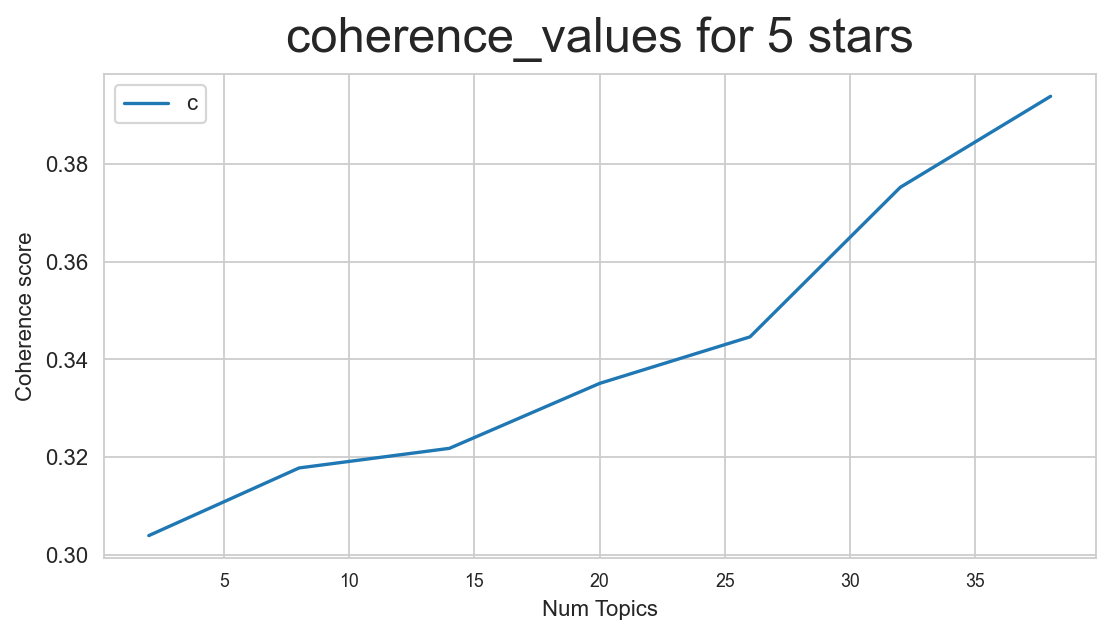

In [205]:
# Show graph for 5 stars
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.figure(figsize=(8,4), dpi=160)
plt.plot(x, coherence_values_5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values for 5 stars"), loc='best')
plt.title('coherence_values for 5 stars', fontdict=dict(size=22),y=1.02)
plt.show()

In [54]:
# Print the coherence scores for 5 stars
for m, cv in zip(x, coherence_values_5):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3039
Num Topics = 8  has Coherence Value of 0.3178
Num Topics = 14  has Coherence Value of 0.3218
Num Topics = 20  has Coherence Value of 0.3351
Num Topics = 26  has Coherence Value of 0.3446
Num Topics = 32  has Coherence Value of 0.3752
Num Topics = 38  has Coherence Value of 0.3939


In [55]:
# Select the model and print the topics for 5 stars
optimal_model_5 = model_list_5[5]
model_topics_5 = optimal_model_5.show_topics(formatted=False)
pprint(optimal_model_5.print_topics(num_words=10))

[(9,
  '0.079*"cartridge" + 0.054*"problem" + 0.041*"laser" + 0.033*"faster" + '
  '0.033*"jet" + 0.029*"straight" + 0.029*"cable" + 0.025*"multi" + '
  '0.025*"change" + 0.021*"instruction"'),
 (15,
  '0.090*"needed" + 0.086*"easily" + 0.040*"iphone" + 0.040*"ipad" + '
  '0.040*"laptop" + 0.036*"place" + 0.036*"head" + 0.032*"show" + '
  '0.029*"difficult" + 0.029*"couple"'),
 (20,
  '0.291*"app" + 0.161*"smart" + 0.083*"phone" + 0.030*"included" + '
  '0.028*"line" + 0.025*"step" + 0.022*"select" + 0.022*"installed" + '
  '0.019*"cardboard" + 0.017*"refill"'),
 (31,
  '0.260*"ink" + 0.056*"setting" + 0.037*"download" + 0.034*"full" + '
  '0.034*"including" + 0.031*"step" + 0.031*"load" + 0.025*"check" + '
  '0.025*"follow" + 0.022*"automatically"'),
 (22,
  '0.113*"device" + 0.093*"simple" + 0.066*"perfect" + 0.050*"desk" + '
  '0.046*"connect" + 0.046*"power" + 0.040*"level" + 0.040*"size" + '
  '0.036*"space" + 0.030*"adjust"'),
 (8,
  '0.270*"photo" + 0.095*"phone" + 0.040*"option

# 3&4 Stars

In [56]:
# Can take a long time to run.
model_list_34, coherence_values_34 = compute_coherence_values(dictionary=id2word_34, corpus=corpus_34, texts=data_words_bigrams_34, start=2, limit=40, step=6)

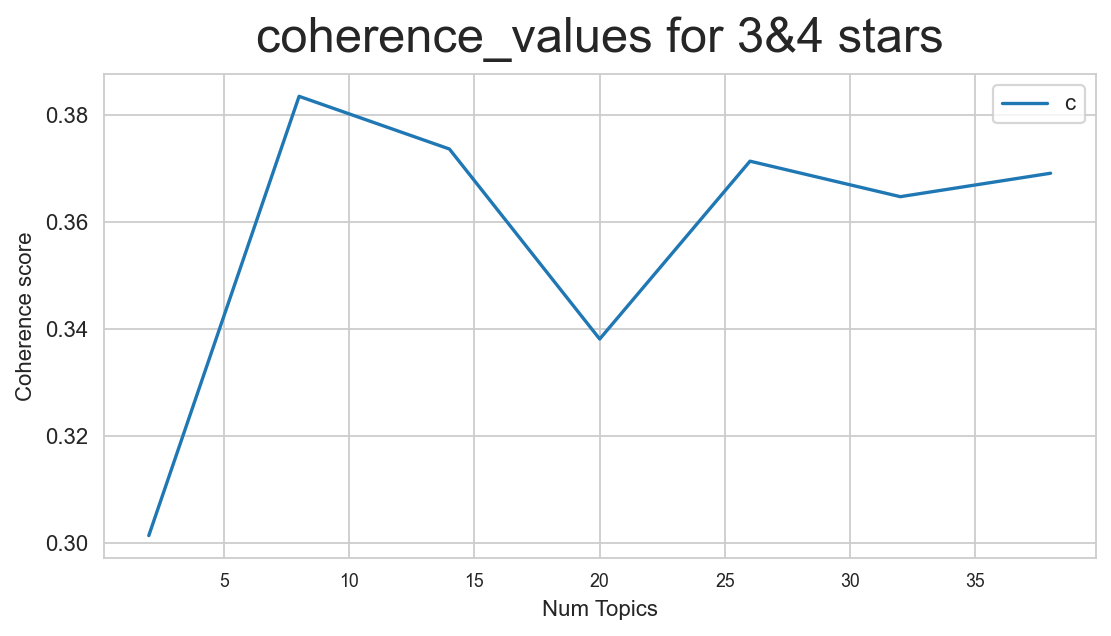

In [207]:
# Show graph for 3&4 stars
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.figure(figsize=(8,4), dpi=160)
plt.plot(x, coherence_values_34)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values for 3&4 stars"), loc='best')
plt.title('coherence_values for 3&4 stars', fontdict=dict(size=22),y=1.02)
plt.show()

In [58]:
# Print the coherence scores for 3&4 stars
for m, cv in zip(x, coherence_values_34):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3014
Num Topics = 8  has Coherence Value of 0.3834
Num Topics = 14  has Coherence Value of 0.3736
Num Topics = 20  has Coherence Value of 0.3381
Num Topics = 26  has Coherence Value of 0.3713
Num Topics = 32  has Coherence Value of 0.3647
Num Topics = 38  has Coherence Value of 0.369


In [59]:
# Select the model and print the topics for 3&4 stars
optimal_model_34 = model_list_34[1]
model_topics_34 = optimal_model_34.show_topics(formatted=False)
pprint(optimal_model_34.print_topics(num_words=10))

[(0,
  '0.084*"ink" + 0.049*"cartridge" + 0.035*"setup" + 0.029*"black" + '
  '0.020*"document" + 0.020*"color" + 0.019*"envy" + 0.019*"great" + '
  '0.015*"image" + 0.015*"button"'),
 (1,
  '0.114*"photo" + 0.052*"app" + 0.032*"picture" + 0.027*"connect" + '
  '0.015*"phone" + 0.015*"wi_fi" + 0.012*"sheet" + 0.012*"product" + '
  '0.011*"connection" + 0.010*"fun"'),
 (2,
  '0.056*"scan" + 0.028*"easy" + 0.026*"tank" + 0.024*"color" + 0.022*"fax" + '
  '0.022*"scanner" + 0.022*"setup" + 0.022*"setting" + 0.021*"screen" + '
  '0.021*"copy"'),
 (3,
  '0.059*"quality" + 0.029*"year" + 0.028*"back" + 0.028*"size" + 0.027*"easy" '
  '+ 0.024*"user" + 0.021*"cartridge" + 0.018*"review" + 0.017*"feel" + '
  '0.015*"model"'),
 (4,
  '0.066*"app" + 0.052*"feature" + 0.042*"work" + 0.026*"wifi" + '
  '0.024*"device" + 0.021*"cost" + 0.021*"instruction" + 0.020*"price" + '
  '0.015*"android" + 0.014*"information"'),
 (5,
  '0.049*"computer" + 0.028*"smart" + 0.028*"phone" + 0.022*"work" + '
  '0.

# 1&2 Stars

In [60]:
# Can take a long time to run.
model_list_12, coherence_values_12 = compute_coherence_values(dictionary=id2word_12, corpus=corpus_12, texts=data_words_bigrams_12, start=2, limit=40, step=6)

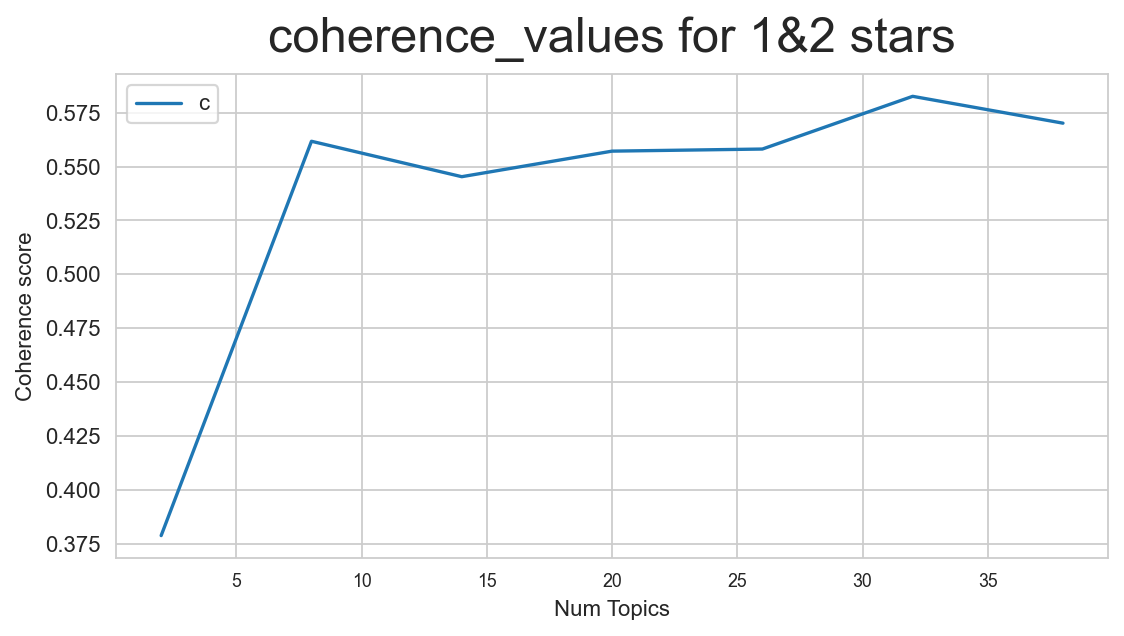

In [208]:
# Show graph for 1&2 stars
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.figure(figsize=(8,4), dpi=160)
plt.plot(x, coherence_values_12)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values for 1&2 stars"), loc='best')
plt.title('coherence_values for 1&2 stars', fontdict=dict(size=22),y=1.02)
plt.show()

In [62]:
# Print the coherence scores for 1&2 stars
for m, cv in zip(x, coherence_values_12):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3788
Num Topics = 8  has Coherence Value of 0.5617
Num Topics = 14  has Coherence Value of 0.5453
Num Topics = 20  has Coherence Value of 0.5571
Num Topics = 26  has Coherence Value of 0.5581
Num Topics = 32  has Coherence Value of 0.5826
Num Topics = 38  has Coherence Value of 0.5701


In [63]:
# Select the model and print the topics for 1&2 stars
optimal_model_12 = model_list_34[1]
model_topics_12 = optimal_model_12.show_topics(formatted=False)
pprint(optimal_model_12.print_topics(num_words=10))

[(0,
  '0.084*"ink" + 0.049*"cartridge" + 0.035*"setup" + 0.029*"black" + '
  '0.020*"document" + 0.020*"color" + 0.019*"envy" + 0.019*"great" + '
  '0.015*"image" + 0.015*"button"'),
 (1,
  '0.114*"photo" + 0.052*"app" + 0.032*"picture" + 0.027*"connect" + '
  '0.015*"phone" + 0.015*"wi_fi" + 0.012*"sheet" + 0.012*"product" + '
  '0.011*"connection" + 0.010*"fun"'),
 (2,
  '0.056*"scan" + 0.028*"easy" + 0.026*"tank" + 0.024*"color" + 0.022*"fax" + '
  '0.022*"scanner" + 0.022*"setup" + 0.022*"setting" + 0.021*"screen" + '
  '0.021*"copy"'),
 (3,
  '0.059*"quality" + 0.029*"year" + 0.028*"back" + 0.028*"size" + 0.027*"easy" '
  '+ 0.024*"user" + 0.021*"cartridge" + 0.018*"review" + 0.017*"feel" + '
  '0.015*"model"'),
 (4,
  '0.066*"app" + 0.052*"feature" + 0.042*"work" + 0.026*"wifi" + '
  '0.024*"device" + 0.021*"cost" + 0.021*"instruction" + 0.020*"price" + '
  '0.015*"android" + 0.014*"information"'),
 (5,
  '0.049*"computer" + 0.028*"smart" + 0.028*"phone" + 0.022*"work" + '
  '0.

# Finding the dominant topic in each sentence

In [64]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [65]:
# 5 stars
df_topic_sents_keywords_5 = format_topics_sentences(ldamodel=optimal_model_5, corpus=corpus_5, texts=data_5)

# Format
df_dominant_topic_5 = df_topic_sents_keywords_5.reset_index()
df_dominant_topic_5.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_5.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             3.0              0.0517   
1            1            30.0              0.1290   
2            2             8.0              0.3110   
3            3            17.0              0.0628   
4            4            26.0              0.1472   

                                            Keywords  \
0  picture, point, party, type, answer, share, su...   
1  great, review, ecotank, received_charge, super...   
2  photo, phone, option, put, detail, ivy, true, ...   
3  quality, excellent, image, worth, big, added, ...   
4  setup, feel, design, made, back, past, read, s...   

                                                Text  
0          product easy friendly simple share friend  
1  pleased ecotank feature made exceeded expectat...  
2  world becomes digital find enjoying product be...  
3                  excellent fast easy great quality  
4  know ideally since everything digital however ...

In [66]:
# 3&4 stars
df_topic_sents_keywords_34 = format_topics_sentences(ldamodel=optimal_model_34, corpus=corpus_34, texts=data_34)

# Format
df_dominant_topic_34 = df_topic_sents_keywords_34.reset_index()
df_dominant_topic_34.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_34.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             2.0              0.2548   
1            1             5.0              0.2436   
2            2             3.0              0.1565   
3            3             1.0              0.1402   
4            4             6.0              0.2240   

                                            Keywords  \
0  scan, easy, tank, color, fax, scanner, setup, ...   
1  computer, smart, phone, work, problem, process...   
2  quality, year, back, size, easy, user, cartrid...   
3  photo, app, picture, connect, phone, wi_fi, sh...   
4  home, small, tray, office, setup, toner, optio...   

                                                Text  
0  ecotank provides basic functionality copy scan...  
1  almost minus fax machine decent overall color ...  
2  found money surprised connect computer initial...  
3  ok priced price full size photo capable purcha...  
4  wfh covid pushed technology item help family m...

In [67]:
# 1&2 stars
df_topic_sents_keywords_12 = format_topics_sentences(ldamodel=optimal_model_12, corpus=corpus_12, texts=data_12)

# Format
df_dominant_topic_12 = df_topic_sents_keywords_12.reset_index()
df_dominant_topic_12.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_12.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             2.0              0.1425   
1            1             2.0              0.1977   
2            2             7.0              0.2064   
3            3             5.0              0.1743   
4            4             3.0              0.1874   

                                            Keywords  \
0  scan, easy, tank, color, fax, scanner, setup, ...   
1  scan, easy, tank, color, fax, scanner, setup, ...   
2  ink, great, inkjet, laser, quality, subscripti...   
3  computer, smart, phone, work, problem, process...   
4  quality, year, back, size, easy, user, cartrid...   

                                                Text  
0                             twice frozen wont turn  
1  positive review either written bot employee ab...  
2  everything embarrassment physically noticeably...  
3  run away bought attempt hopefully switch graph...  
4  reason let zero self healing wifi disconnect n...

# Find the most representative document for each topic

In [70]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet_5 = pd.DataFrame()

sent_topics_outdf_grpd_5 = df_topic_sents_keywords_5.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_5:
    sent_topics_sorteddf_mallet_5 = pd.concat([sent_topics_sorteddf_mallet_5, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet_5.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet_5.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet_5[:5]

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.0952   
1        1.0              0.2513   
2        2.0              0.3262   
3        3.0              0.3793   
4        4.0              0.2917   

                                            Keywords  \
0  easy, android, install, control, network, upda...   
1  friend, working, support, brand, online, bough...   
2  computer, email, option, software, document, s...   
3  picture, point, party, type, answer, share, su...   
4  tank, ink, job, filling, instruction, fill, bl...   

                                                Text  
0  workforce wf exactly easy install needed home ...  
1  return brand gift friend purchased friend retu...  
2  quality product officejet exception personal s...  
3  party whaaat party include celebration reunion...  
4  ecotank arrived securely packaged everything n...

In [71]:
# Group top 3&4 sentences under each topic
sent_topics_sorteddf_mallet_34 = pd.DataFrame()

sent_topics_outdf_grpd_34 = df_topic_sents_keywords_34.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_34:
    sent_topics_sorteddf_mallet_34 = pd.concat([sent_topics_sorteddf_mallet_34, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet_34.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet_34.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet_34

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.8062   
1        1.0              0.4600   
2        2.0              0.4427   
3        3.0              0.5526   
4        4.0              0.4555   
5        5.0              0.4560   
6        6.0              0.4064   
7        7.0              0.7376   

                                            Keywords  \
0  ink, cartridge, setup, black, document, color,...   
1  photo, app, picture, connect, phone, wi_fi, sh...   
2  scan, easy, tank, color, fax, scanner, setup, ...   
3  quality, year, back, size, easy, user, cartrid...   
4  app, feature, work, wifi, device, cost, instru...   
5  computer, smart, phone, work, problem, process...   
6  home, small, tray, office, setup, toner, optio...   
7  ink, great, inkjet, laser, quality, subscripti...   

                                                Text  
0  hardest part unboxing setup envy getting ink c...  
1  selphy square small portable meant photo call ...  
2  unboxing super easy bag handle easily remove b...  
3  shopping around reading review etc settled bal...  
4  sprocket nd edition us ink instead heat zink r...  
5  aspect review scanner copier fax machine setup...  
6  changed style standard black aio three tone co...  
7  envy wireless inkjet instant ink included summ...

In [72]:
# Group top 1&2 sentences under each topic
sent_topics_sorteddf_mallet_12 = pd.DataFrame()

sent_topics_outdf_grpd_12 = df_topic_sents_keywords_12.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_12:
    sent_topics_sorteddf_mallet_12 = pd.concat([sent_topics_sorteddf_mallet_12, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet_12.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet_12.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet_12

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.4054   
1        1.0              0.2315   
2        2.0              0.2300   
3        3.0              0.2558   
4        4.0              0.1830   
5        5.0              0.1956   
6        6.0              0.1989   
7        7.0              0.4395   

                                            Keywords  \
0  ink, cartridge, setup, black, document, color,...   
1  photo, app, picture, connect, phone, wi_fi, sh...   
2  scan, easy, tank, color, fax, scanner, setup, ...   
3  quality, year, back, size, easy, user, cartrid...   
4  app, feature, work, wifi, device, cost, instru...   
5  computer, smart, phone, work, problem, process...   
6  home, small, tray, office, setup, toner, optio...   
7  ink, great, inkjet, laser, quality, subscripti...   

                                                Text  
0  digital renaissance spurred digital camera ear...  
1  picked today bestbuy honestly expecting true p...  
2  might basic shape small item biggest tray move...  
3  vast amount experience device year confidently...  
4  mix feeling scan fax copy struggle something p...  
5  possibly worst investment ever made literally ...  
6  wish machine wonderful truth recommended keep ...  
7  low budget price basic feature wireless especi...

# Topic distribution across documents

In [73]:
# 5 stars
# Number of Documents for Each Topic
topic_counts_5 = df_topic_sents_keywords_5['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution_5 = round(topic_counts_5/topic_counts_5.sum(), 4)

# Topic Number and Keywords
topic_num_keywords_5 = df_topic_sents_keywords_5[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics_5 = pd.concat([topic_num_keywords_5, topic_counts_5, topic_contribution_5], axis=1)

# Change Column names
df_dominant_topics_5.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_5[:5]

Dominant_Topic                                     Topic_Keywords  \
0.0             3.0  picture, point, party, type, answer, share, su...   
1.0            30.0  great, review, ecotank, received_charge, super...   
2.0             8.0  photo, phone, option, put, detail, ivy, true, ...   
3.0            17.0  quality, excellent, image, worth, big, added, ...   
4.0            26.0  setup, feel, design, made, back, past, read, s...   
5.0             7.0  wifi, setup, fax, connect, long, solid, price,...   

     Num_Documents  Perc_Documents  
0.0            5.0          0.0333  
1.0           10.0          0.0667  
2.0            2.0          0.0133  
3.0           10.0          0.0667  
4.0            3.0          0.0200  
5.0            5.0          0.0333

In [74]:
# 3&4 stars
# Number of Documents for Each Topic
topic_counts_34 = df_topic_sents_keywords_34['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution_34 = round(topic_counts_34/topic_counts_34.sum(), 4)

# Topic Number and Keywords
topic_num_keywords_34 = df_topic_sents_keywords_34[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics_34 = pd.concat([topic_num_keywords_34, topic_counts_34, topic_contribution_34], axis=1)

# Change Column names
df_dominant_topics_34.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_34.head()

Dominant_Topic                                     Topic_Keywords  \
0.0             2.0  scan, easy, tank, color, fax, scanner, setup, ...   
1.0             5.0  computer, smart, phone, work, problem, process...   
2.0             3.0  quality, year, back, size, easy, user, cartrid...   
3.0             1.0  photo, app, picture, connect, phone, wi_fi, sh...   
4.0             6.0  home, small, tray, office, setup, toner, optio...   

     Num_Documents  Perc_Documents  
0.0           11.0          0.0733  
1.0           23.0          0.1533  
2.0           23.0          0.1533  
3.0           24.0          0.1600  
4.0           17.0          0.1133

In [75]:
# 1&2 stars
# Number of Documents for Each Topic
topic_counts_12 = df_topic_sents_keywords_12['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution_12 = round(topic_counts_12/topic_counts_12.sum(), 4)

# Topic Number and Keywords
topic_num_keywords_12 = df_topic_sents_keywords_12[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics_12 = pd.concat([topic_num_keywords_12, topic_counts_12, topic_contribution_12], axis=1)

# Change Column names
df_dominant_topics_12.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_12.head()

Dominant_Topic                                     Topic_Keywords  \
0.0             2.0  scan, easy, tank, color, fax, scanner, setup, ...   
1.0             2.0  scan, easy, tank, color, fax, scanner, setup, ...   
2.0             7.0  ink, great, inkjet, laser, quality, subscripti...   
3.0             5.0  computer, smart, phone, work, problem, process...   
4.0             3.0  quality, year, back, size, easy, user, cartrid...   

     Num_Documents  Perc_Documents  
0.0            8.0          0.1270  
1.0            5.0          0.0794  
2.0           10.0          0.1587  
3.0            7.0          0.1111  
4.0            4.0          0.0635

# 5 Stars Frequency Distribution in Document and Each Topic

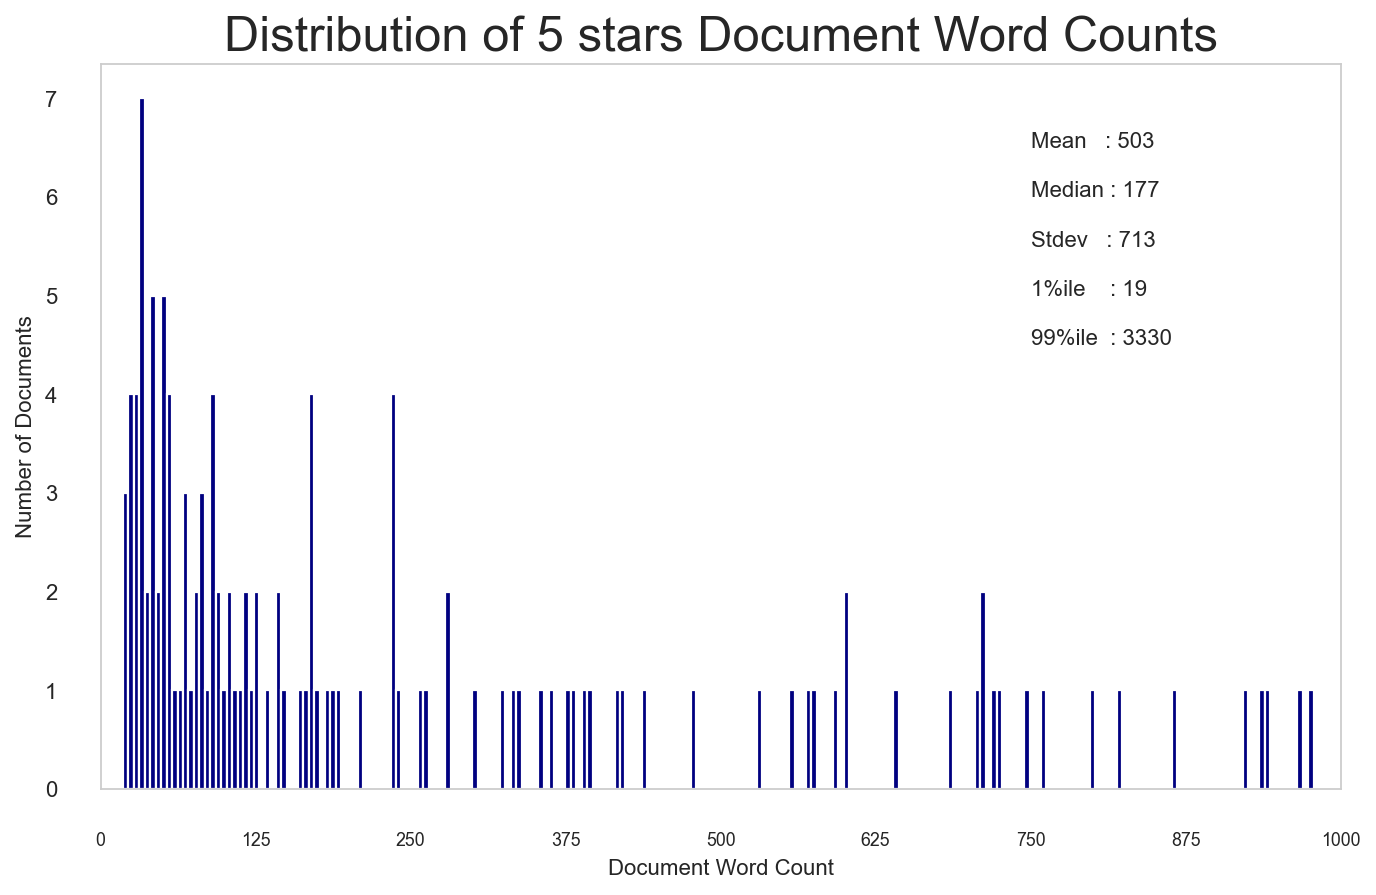

In [209]:
doc_lens_5 = [len(d) for d in df_dominant_topic_5.Text]

# Plot
plt.figure(figsize=(10,6), dpi=160)
plt.hist(doc_lens_5, bins = 1000, color='navy')
plt.text(750, 6.5, "Mean   : " + str(round(np.mean(doc_lens_5))))
plt.text(750, 6, "Median : " + str(round(np.median(doc_lens_5))))
plt.text(750, 5.5, "Stdev   : " + str(round(np.std(doc_lens_5))))
plt.text(750, 5, "1%ile    : " + str(round(np.quantile(doc_lens_5, q=0.01))))
plt.text(750, 4.5, "99%ile  : " + str(round(np.quantile(doc_lens_5, q=0.99))))

plt.grid(b=None)
plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of 5 stars Document Word Counts', fontdict=dict(size=22))
plt.show()

C:\Users\Kangping\AppData\Local\Temp/ipykernel_29832/1647532600.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_5.loc[df_5.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


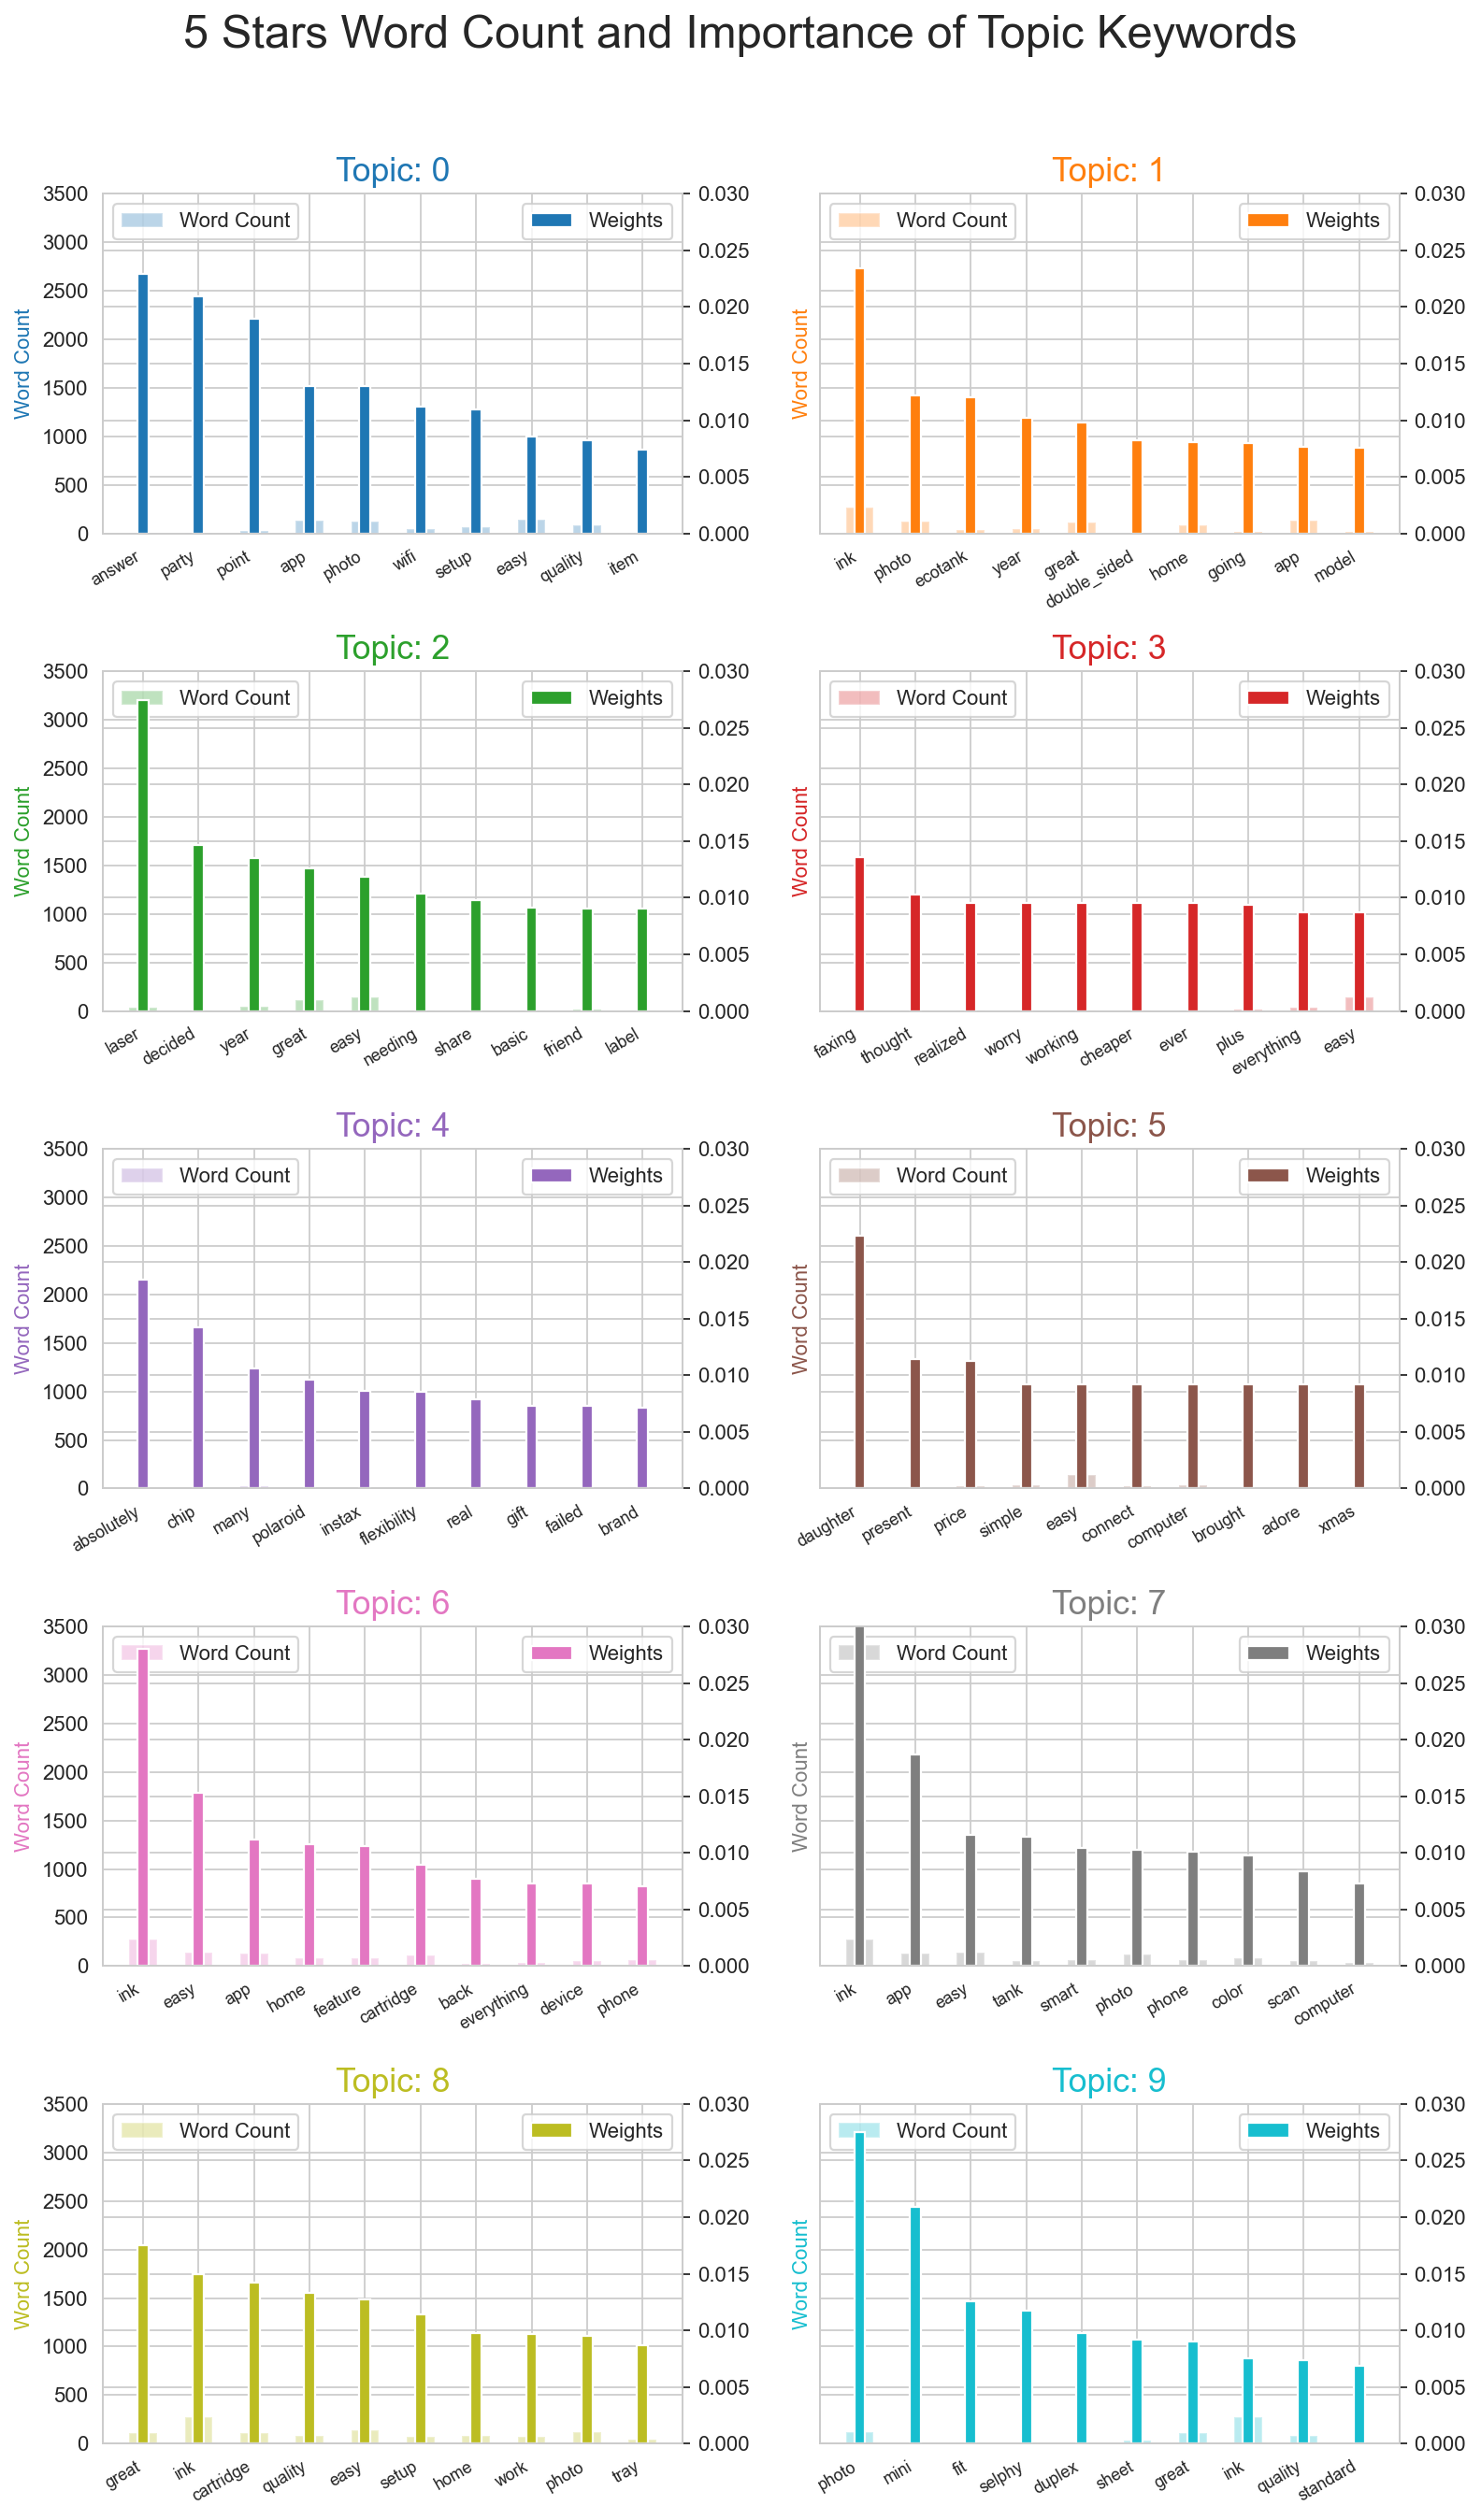

In [189]:
from collections import Counter
topics_5 = lda_model_5.show_topics(formatted=False)
data_flat_5 = [w for w_list in words_5 for w in w_list]
counter_5 = Counter(data_flat_5)

out = []
for i, topic in topics_5:
    for word, weight in topic:
        out.append([word, i , weight, counter_5[word]])

df_5 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_5.loc[df_5.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_5.loc[df_5.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_5.loc[df_5.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('5 Stars Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

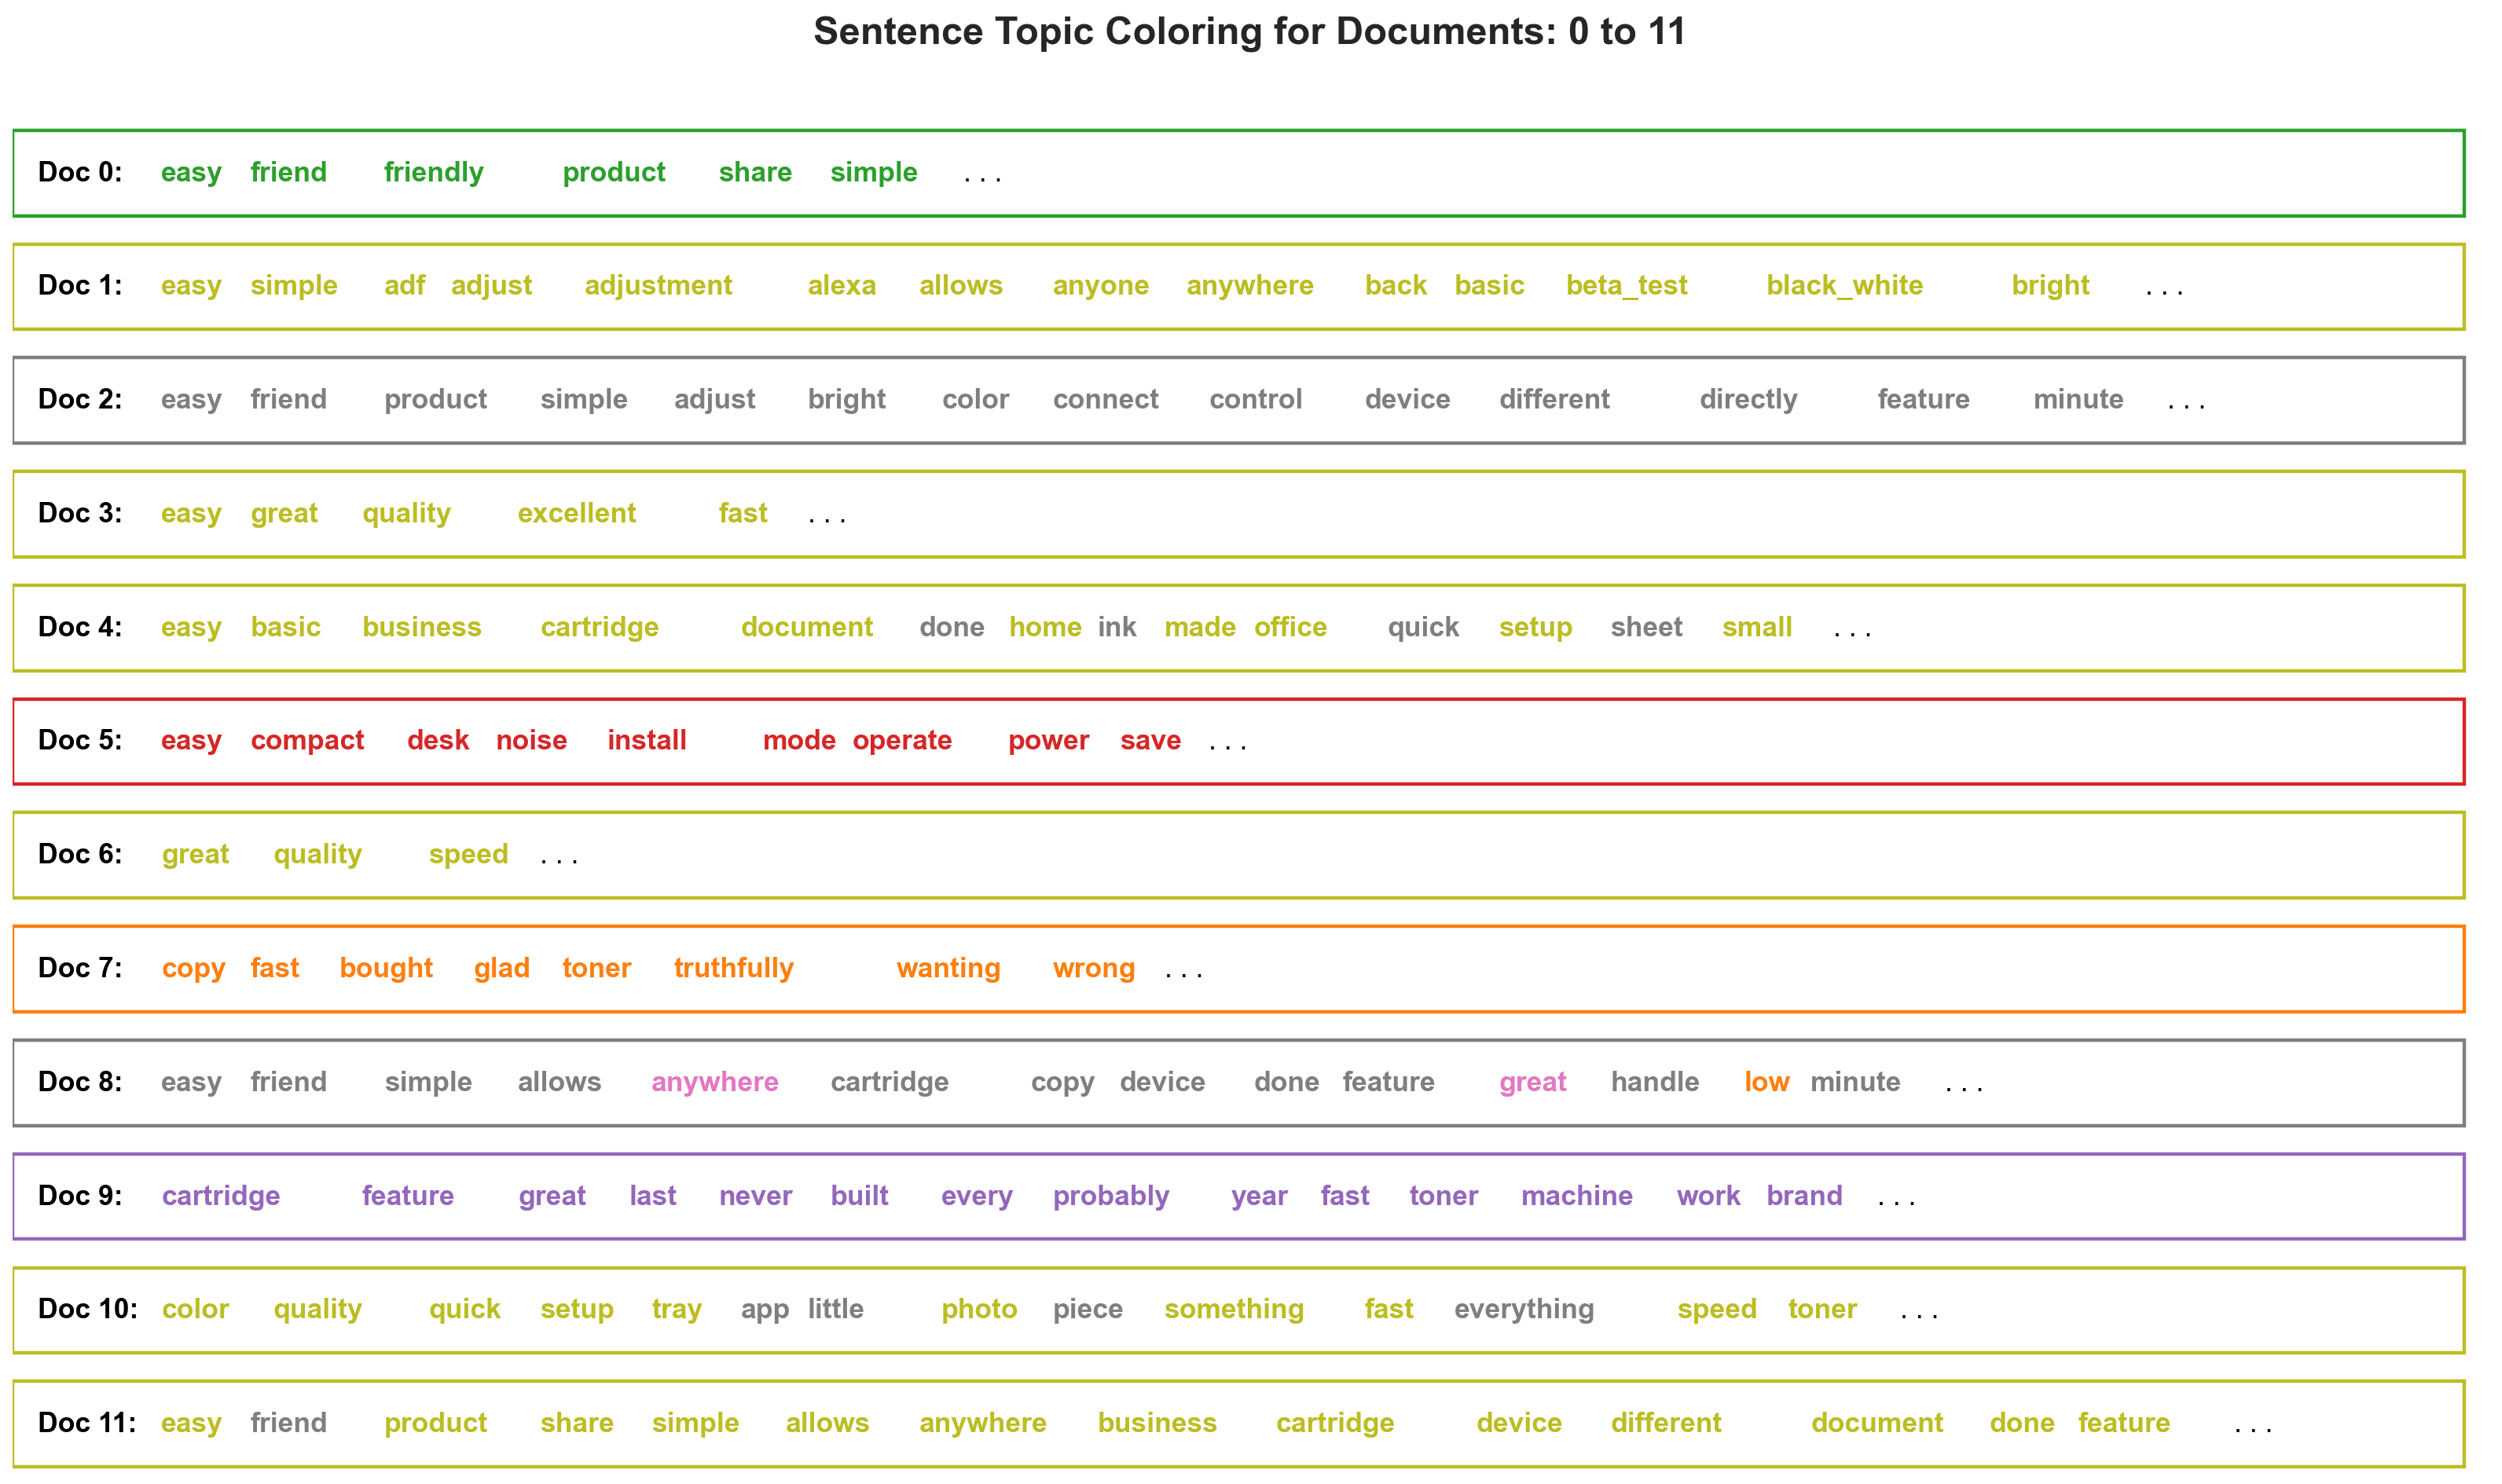

In [86]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model_5, corpus=corpus_5, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('5 Stars Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

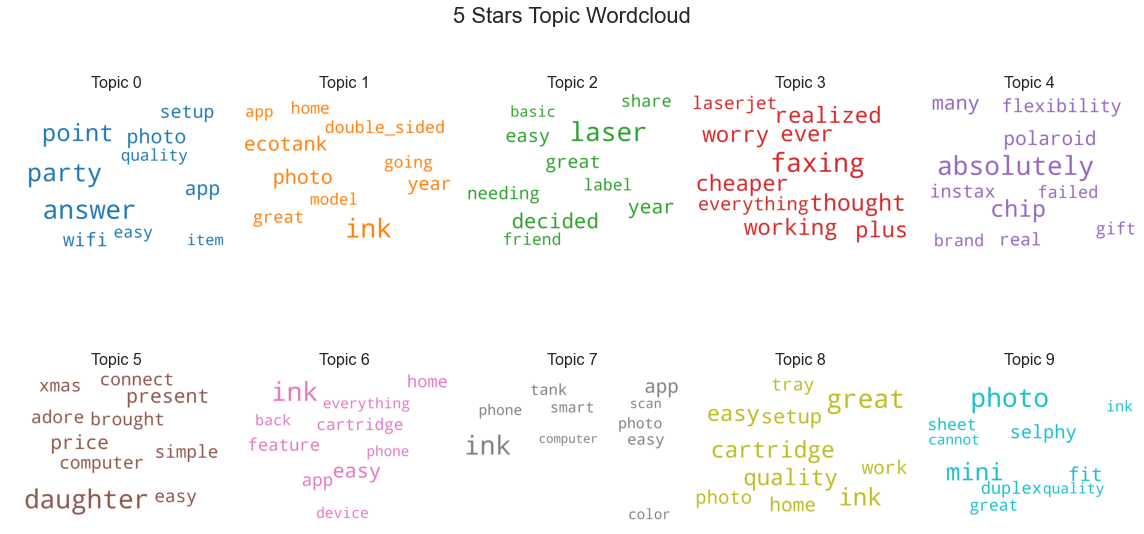

In [96]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics_5 = lda_model_5.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_5[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

fig.suptitle('5 Stars Topic Wordcloud', fontsize=22,y=0.9)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [102]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics_5, topic_percentages_5 = topics_per_document(model=lda_model_5, corpus=corpus_5, end=-1)            

# Distribution of Dominant Topics in Each Document
df_5 = pd.DataFrame(dominant_topics_5, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_5 = df_5.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_5 = dominant_topic_in_each_doc_5.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_5 = pd.DataFrame([dict(t) for t in topic_percentages_5])
df_topic_weightage_by_doc_5 = topic_weightage_by_doc_5.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words_5 = [(i, topic) for i, topics in lda_model_5.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked_5 = pd.DataFrame(topic_top3words_5, columns=['topic_id', 'words'])
df_top3words_5 = df_top3words_stacked_5.groupby('topic_id').agg(', \n'.join)
df_top3words_5.reset_index(level=0,inplace=True)

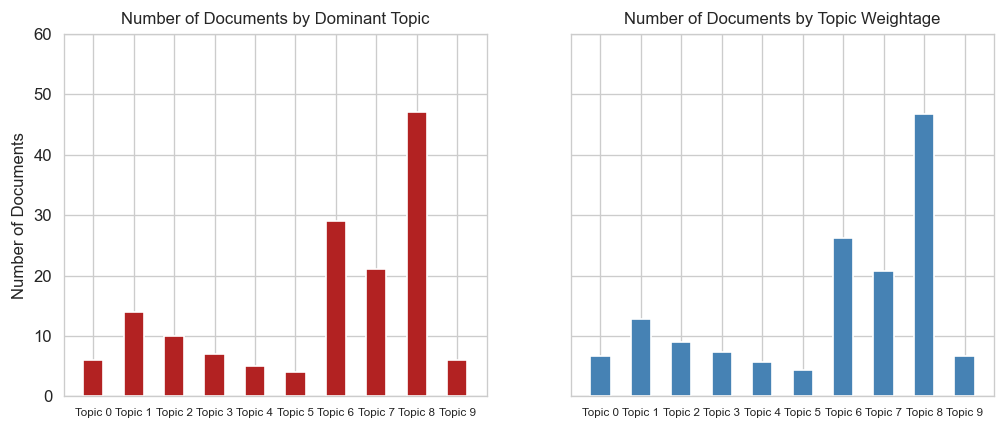

In [148]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

tick_formatter_5 = FuncFormatter(lambda x, pos: 'Topic ' + str(x))
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_5, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc_5.Dominant_Topic.unique().__len__()))
ax1.xaxis.set_major_formatter(tick_formatter_5)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 60)
ax1.xaxis.set_tick_params(labelsize=7)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_5, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_5.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter_5)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.xaxis.set_tick_params(labelsize=7)

plt.show()

# 3&4 Stars Frequency Distribution in Document and Each Topic

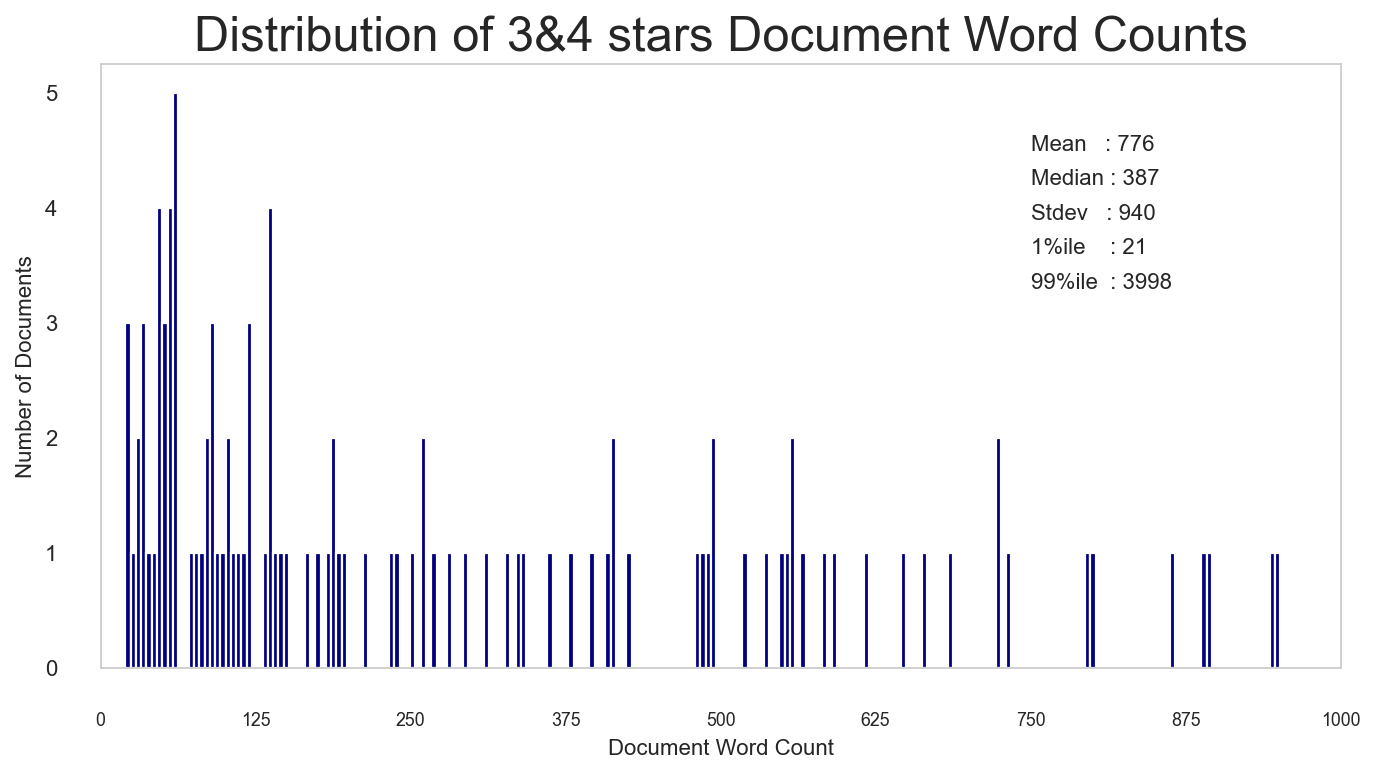

In [210]:
doc_lens_34 = [len(d) for d in df_dominant_topic_34.Text]

# Plot
plt.figure(figsize=(10,5), dpi=160)
plt.hist(doc_lens_34, bins = 1000, color='navy')
plt.text(750, 4.5, "Mean   : " + str(round(np.mean(doc_lens_34))))
plt.text(750, 4.2, "Median : " + str(round(np.median(doc_lens_34))))
plt.text(750, 3.9, "Stdev   : " + str(round(np.std(doc_lens_34))))
plt.text(750, 3.6, "1%ile    : " + str(round(np.quantile(doc_lens_34, q=0.01))))
plt.text(750, 3.3, "99%ile  : " + str(round(np.quantile(doc_lens_34, q=0.99))))

plt.grid(b=None)
plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of 3&4 stars Document Word Counts', fontdict=dict(size=22))
plt.show()

C:\Users\Kangping\AppData\Local\Temp/ipykernel_29832/1094788184.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_34.loc[df_34.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


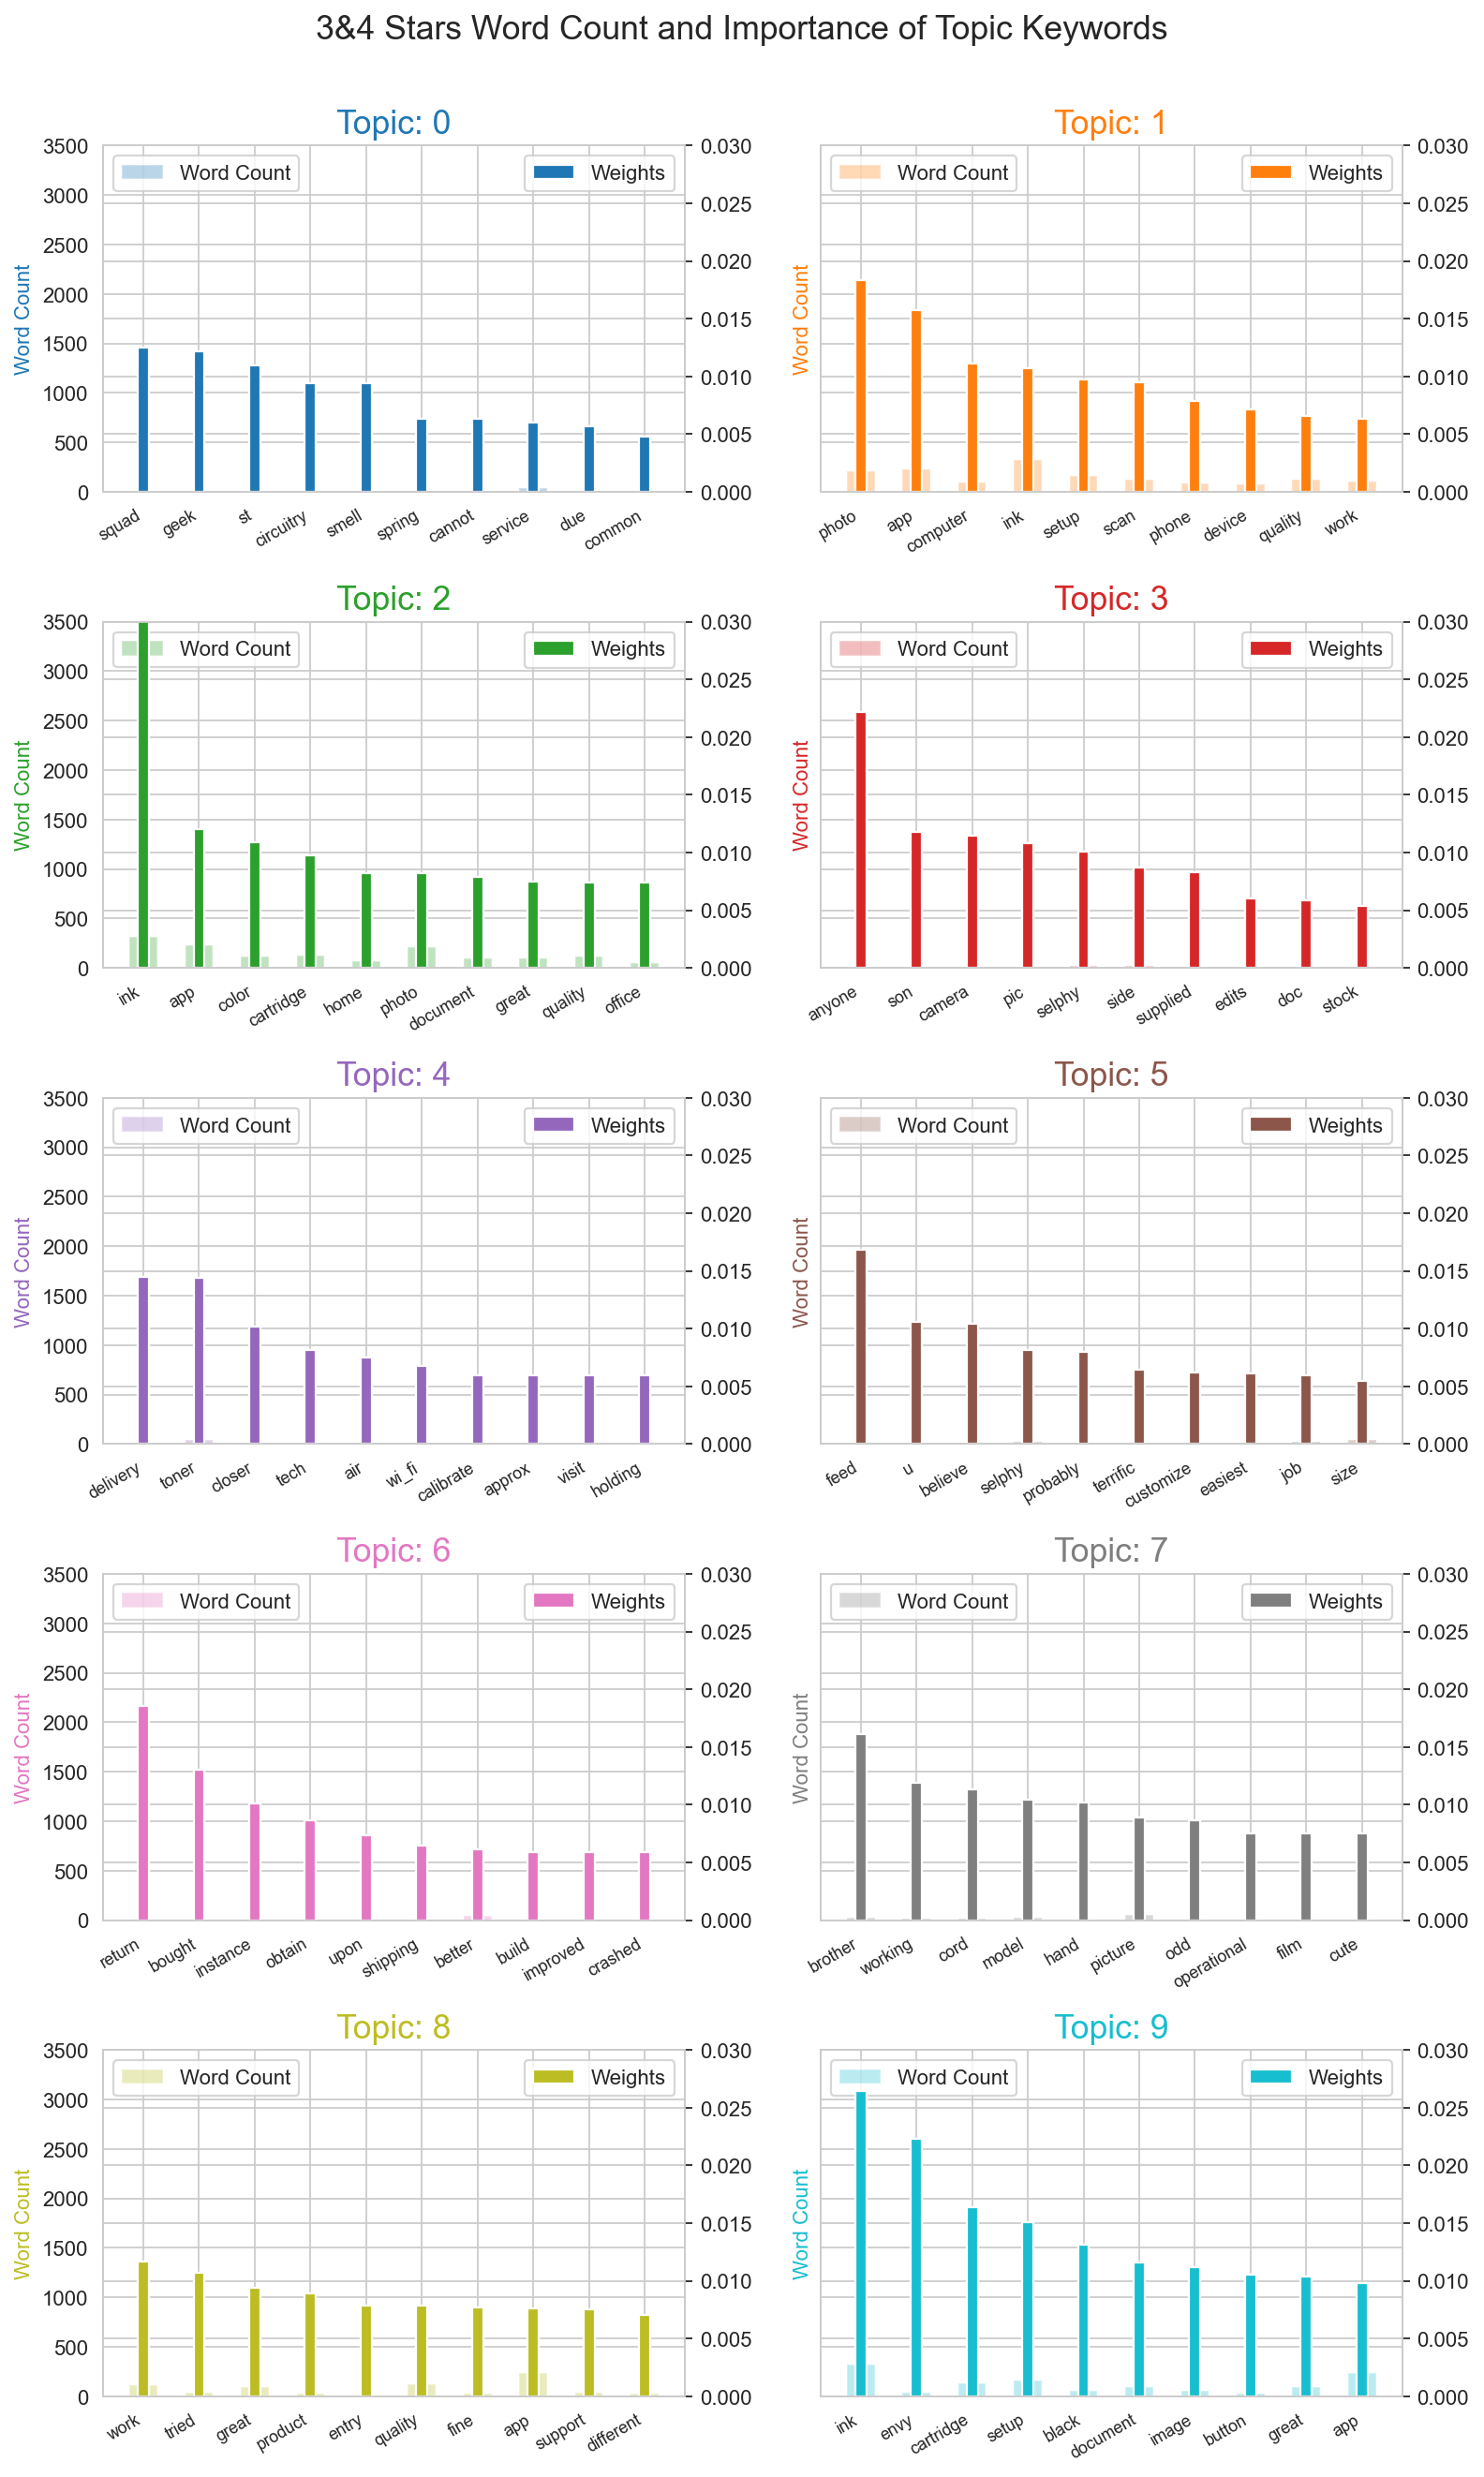

In [172]:
from collections import Counter
topics_34 = lda_model_34.show_topics(formatted=False)
data_flat_34 = [w for w_list in words_34 for w in w_list]
counter_34 = Counter(data_flat_34)

out = []
for i, topic in topics_34:
    for word, weight in topic:
        out.append([word, i , weight, counter_34[word]])

df_34 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_34.loc[df_34.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_34.loc[df_34.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_34.loc[df_34.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('3&4 Stars Word Count and Importance of Topic Keywords', fontsize=16, y=1.03)    
plt.show()

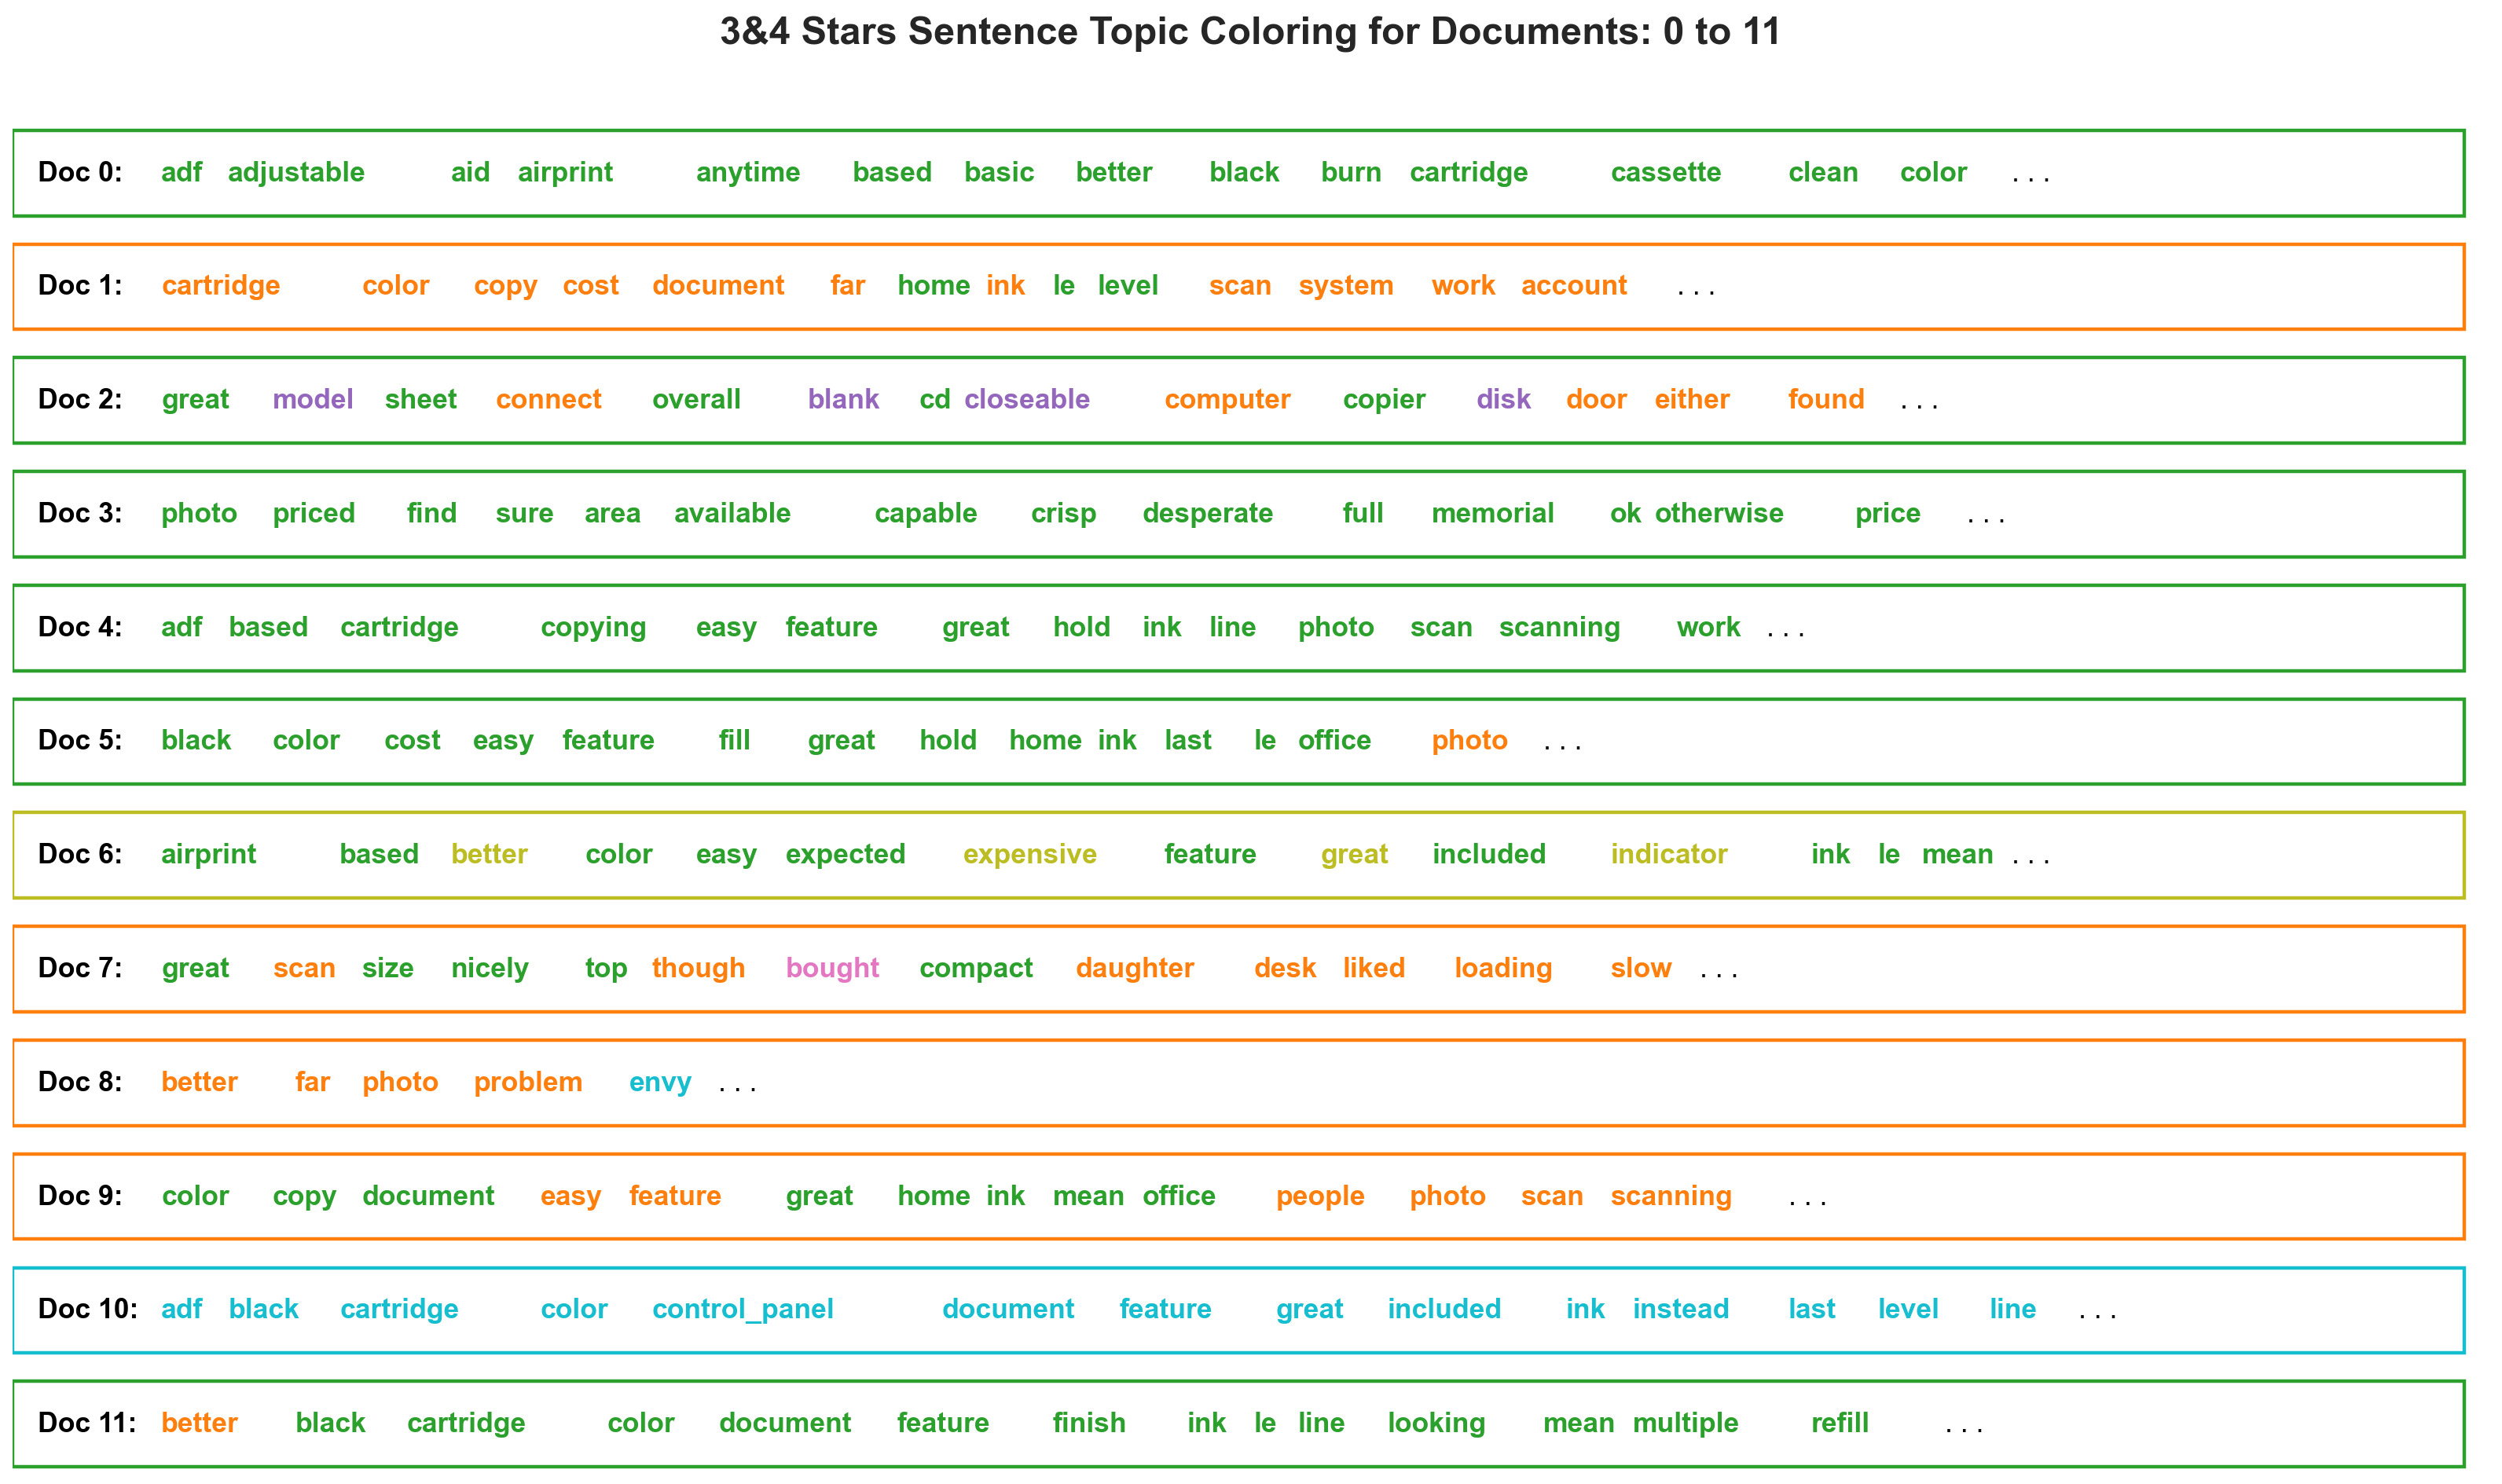

In [163]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model_34, corpus=corpus_34, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('3&4 Stars Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

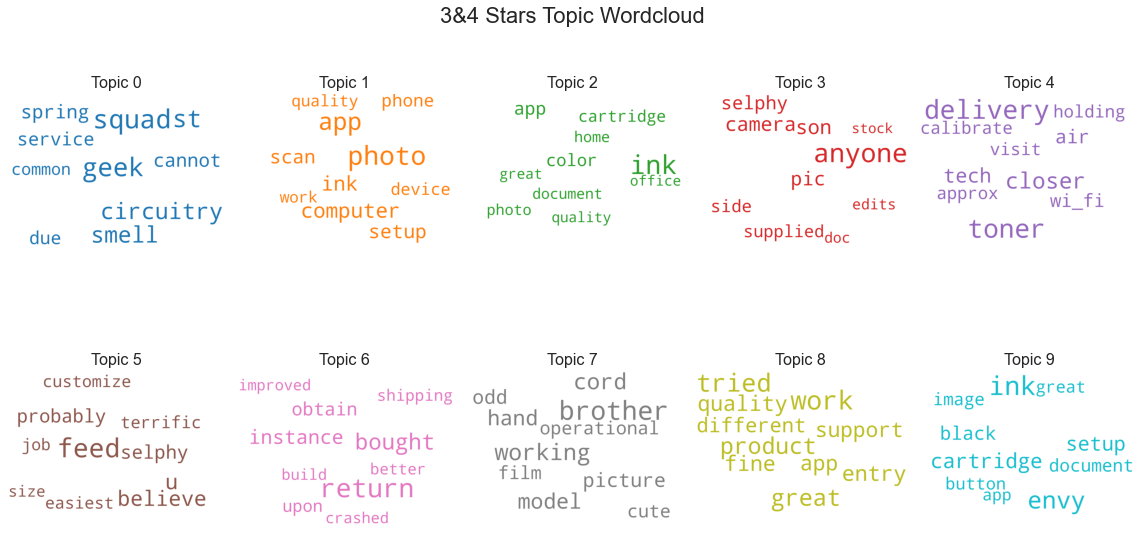

In [162]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics_34 = lda_model_34.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_34[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

fig.suptitle('3&4 Stars Topic Wordcloud', fontsize=22,y=0.9)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [173]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics_34, topic_percentages_34 = topics_per_document(model=lda_model_34, corpus=corpus_34, end=-1)            

# Distribution of Dominant Topics in Each Document
df_34= pd.DataFrame(dominant_topics_34, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_34=df_34.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_34= dominant_topic_in_each_doc_34.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_34= pd.DataFrame([dict(t) for t in topic_percentages_34])
df_topic_weightage_by_doc_34= topic_weightage_by_doc_34.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words_34= [(i, topic) for i, topics in lda_model_34.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked_34= pd.DataFrame(topic_top3words_34,columns=['topic_id', 'words'])
df_top3words_34= df_top3words_stacked_34.groupby('topic_id').agg(', \n'.join)
df_top3words_34.reset_index(level=0,inplace=True)

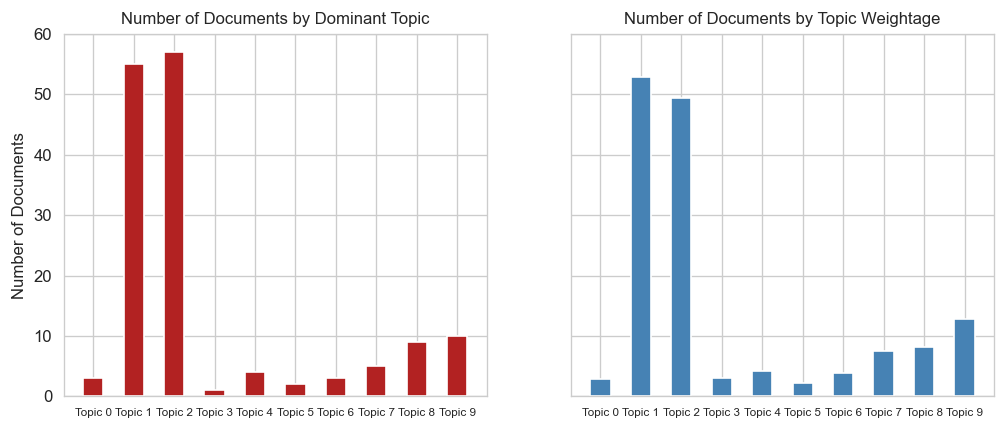

In [174]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

tick_formatter_34 = FuncFormatter(lambda x, pos: 'Topic ' + str(x))
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_34, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc_34.Dominant_Topic.unique().__len__()))
ax1.xaxis.set_major_formatter(tick_formatter_34)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 60)
ax1.xaxis.set_tick_params(labelsize=7)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_34, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_34.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter_34)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.xaxis.set_tick_params(labelsize=7)

plt.show()

# 1&2 Stars Frequency Distribution in Document and Each Topic

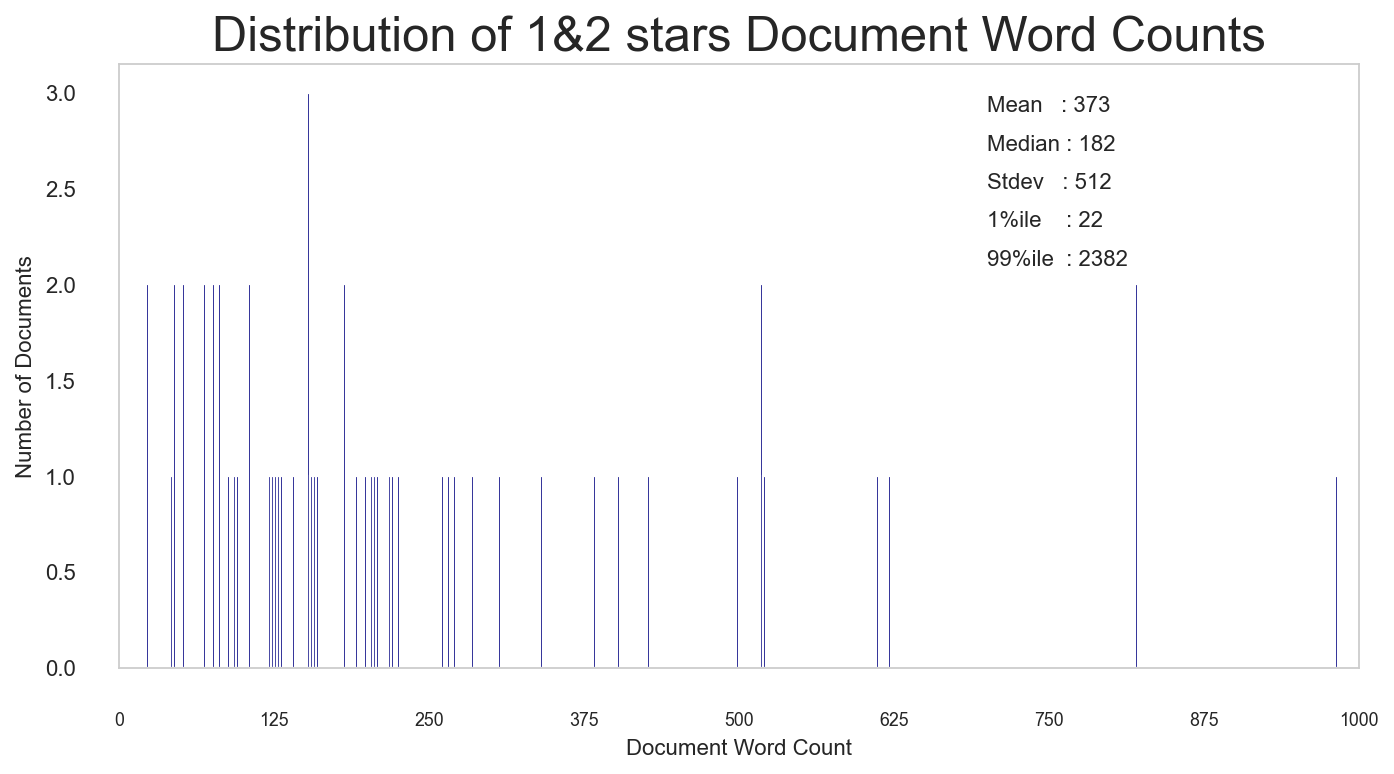

In [211]:
doc_lens_12 = [len(d) for d in df_dominant_topic_12.Text]

# Plot
plt.figure(figsize=(10,5), dpi=160)
plt.hist(doc_lens_12, bins = 1000, color='navy')
plt.text(700, 2.9, "Mean   : " + str(round(np.mean(doc_lens_12))))
plt.text(700, 2.7, "Median : " + str(round(np.median(doc_lens_12))))
plt.text(700, 2.5, "Stdev   : " + str(round(np.std(doc_lens_12))))
plt.text(700, 2.3, "1%ile    : " + str(round(np.quantile(doc_lens_12, q=0.01))))
plt.text(700, 2.1, "99%ile  : " + str(round(np.quantile(doc_lens_12, q=0.99))))

plt.grid(b=None)
plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of 1&2 stars Document Word Counts', fontdict=dict(size=22))
plt.show()

C:\Users\Kangping\AppData\Local\Temp/ipykernel_29832/3527789266.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_12.loc[df_12.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


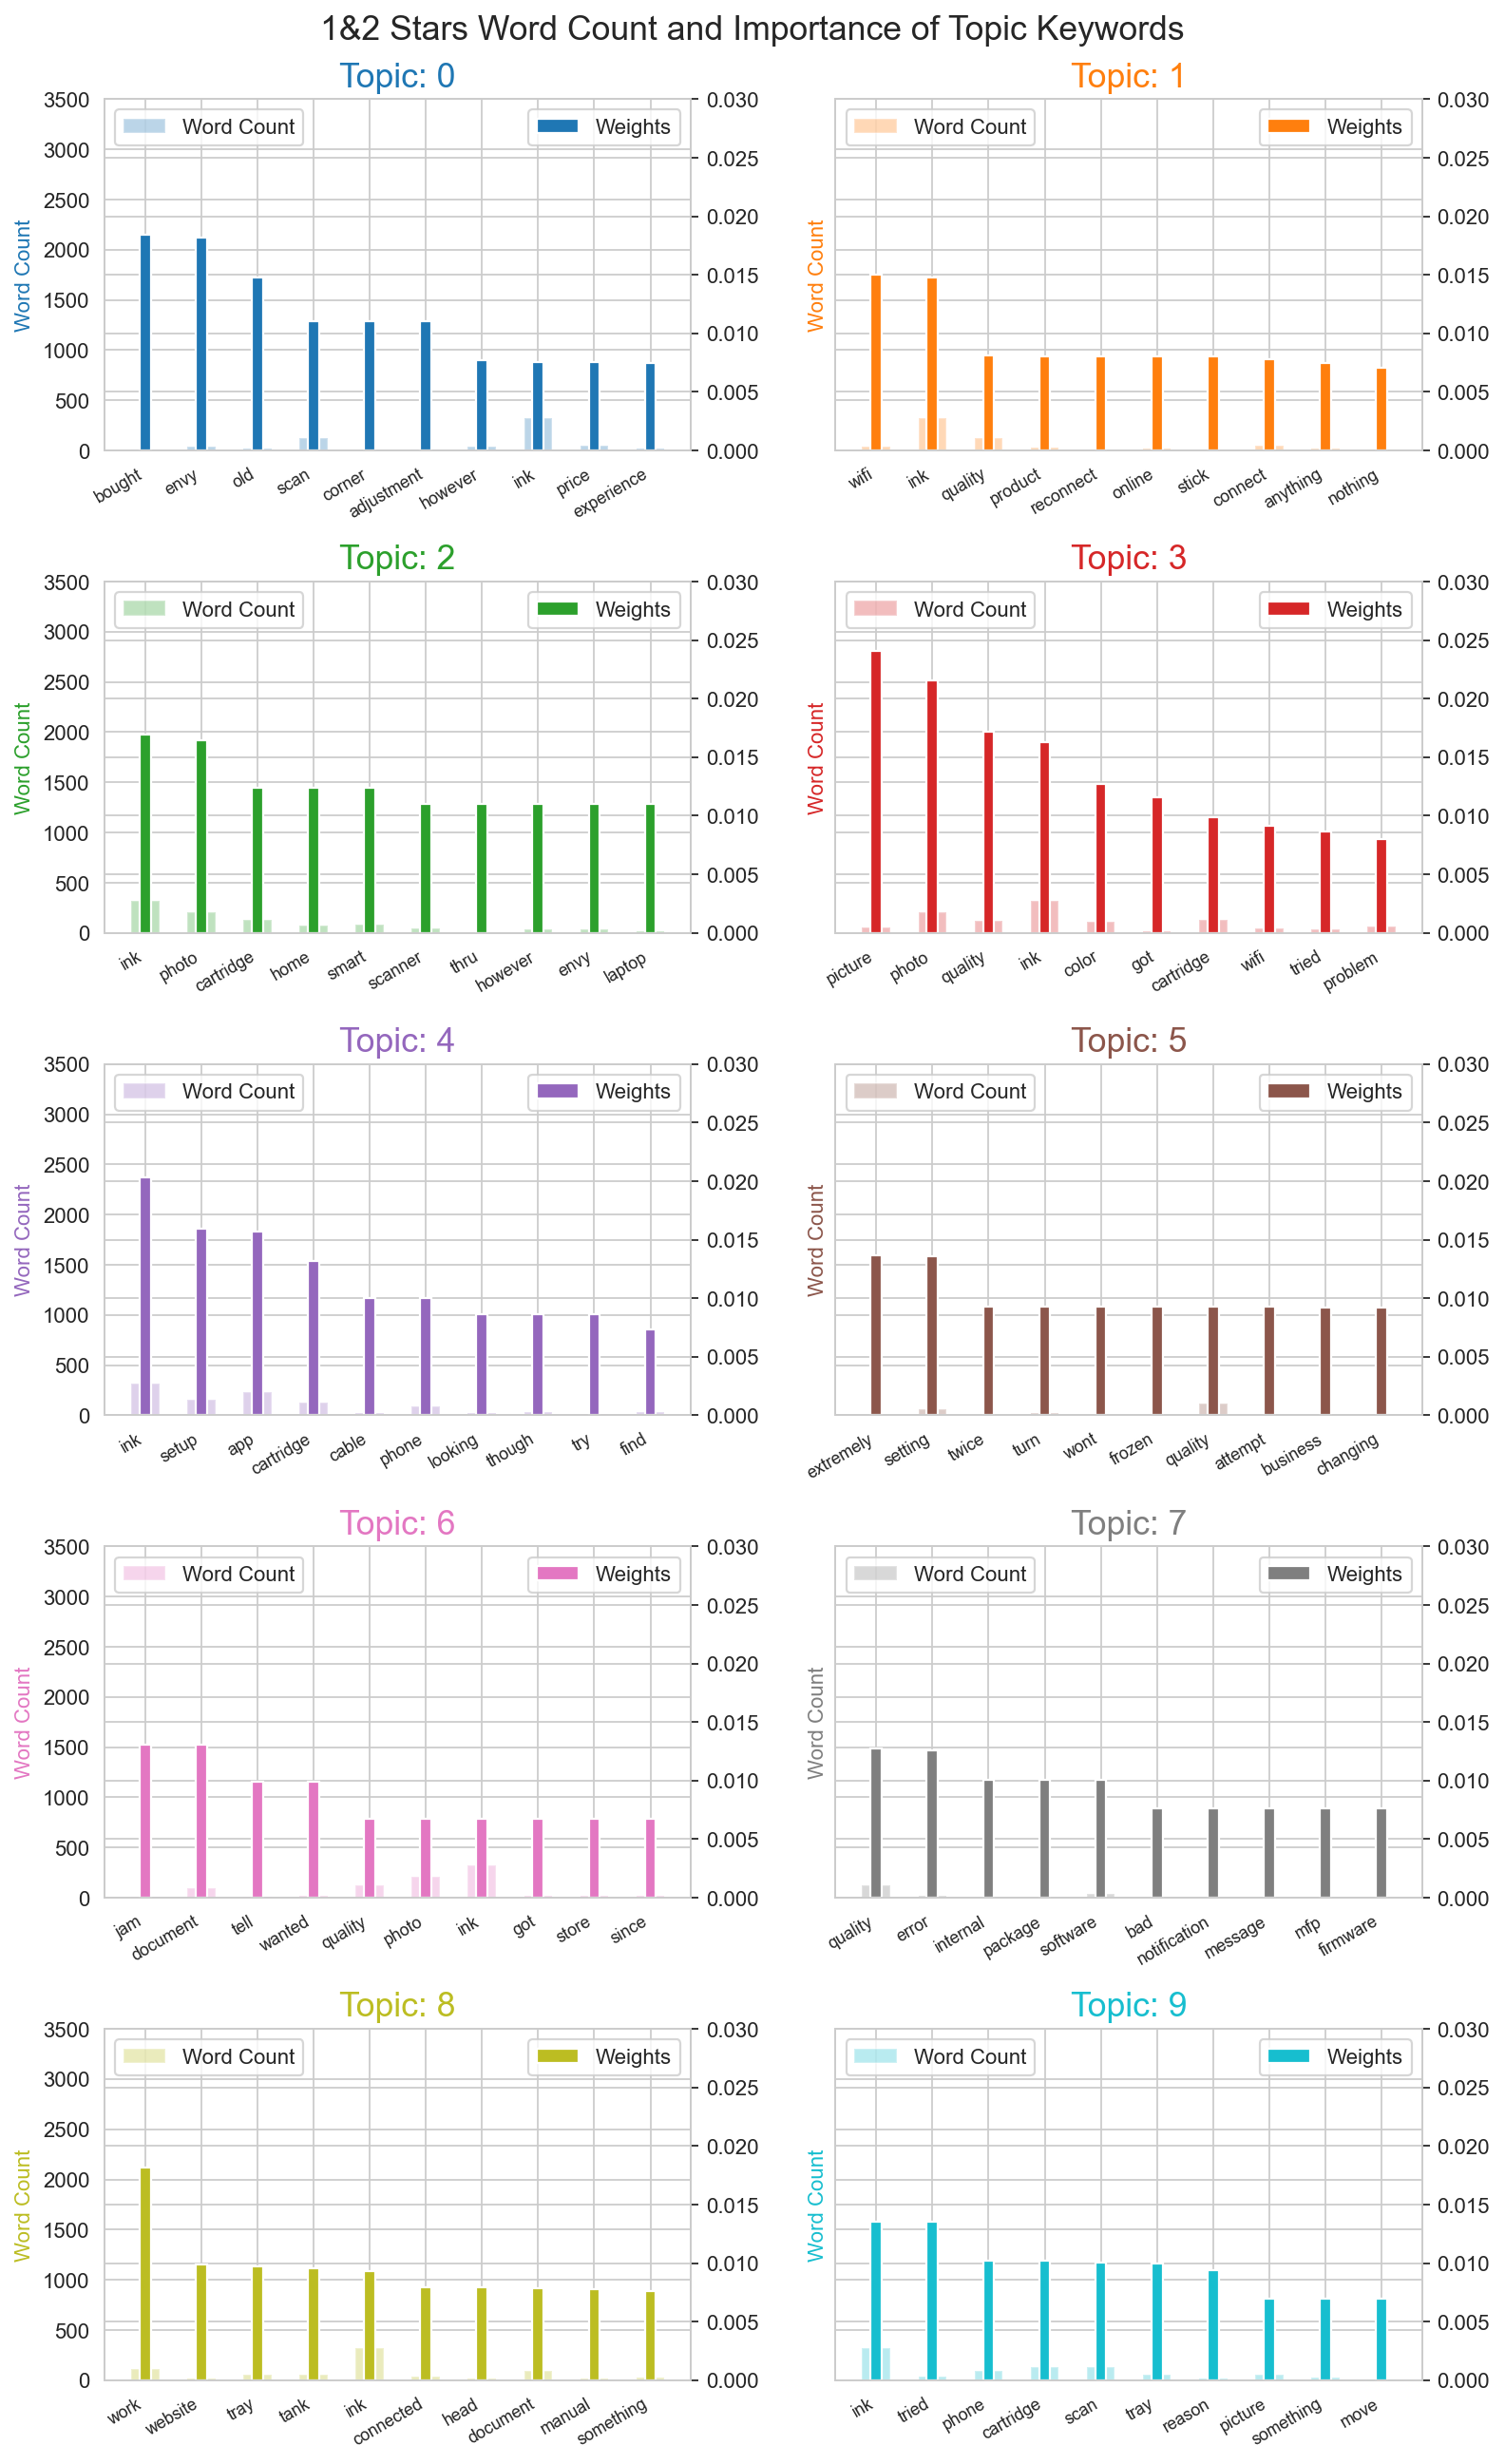

In [184]:
topics_12 = lda_model_12.show_topics(formatted=False)
data_flat_12 = [w for w_list in words_12 for w in w_list]
counter_12 = Counter(data_flat_12)

out = []
for i, topic in topics_12:
    for word, weight in topic:
        out.append([word, i , weight, counter_34[word]])

df_12 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_12.loc[df_12.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_12.loc[df_12.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_12.loc[df_12.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('1&2 Stars Word Count and Importance of Topic Keywords', fontsize=16, y=1.01)    
plt.show()

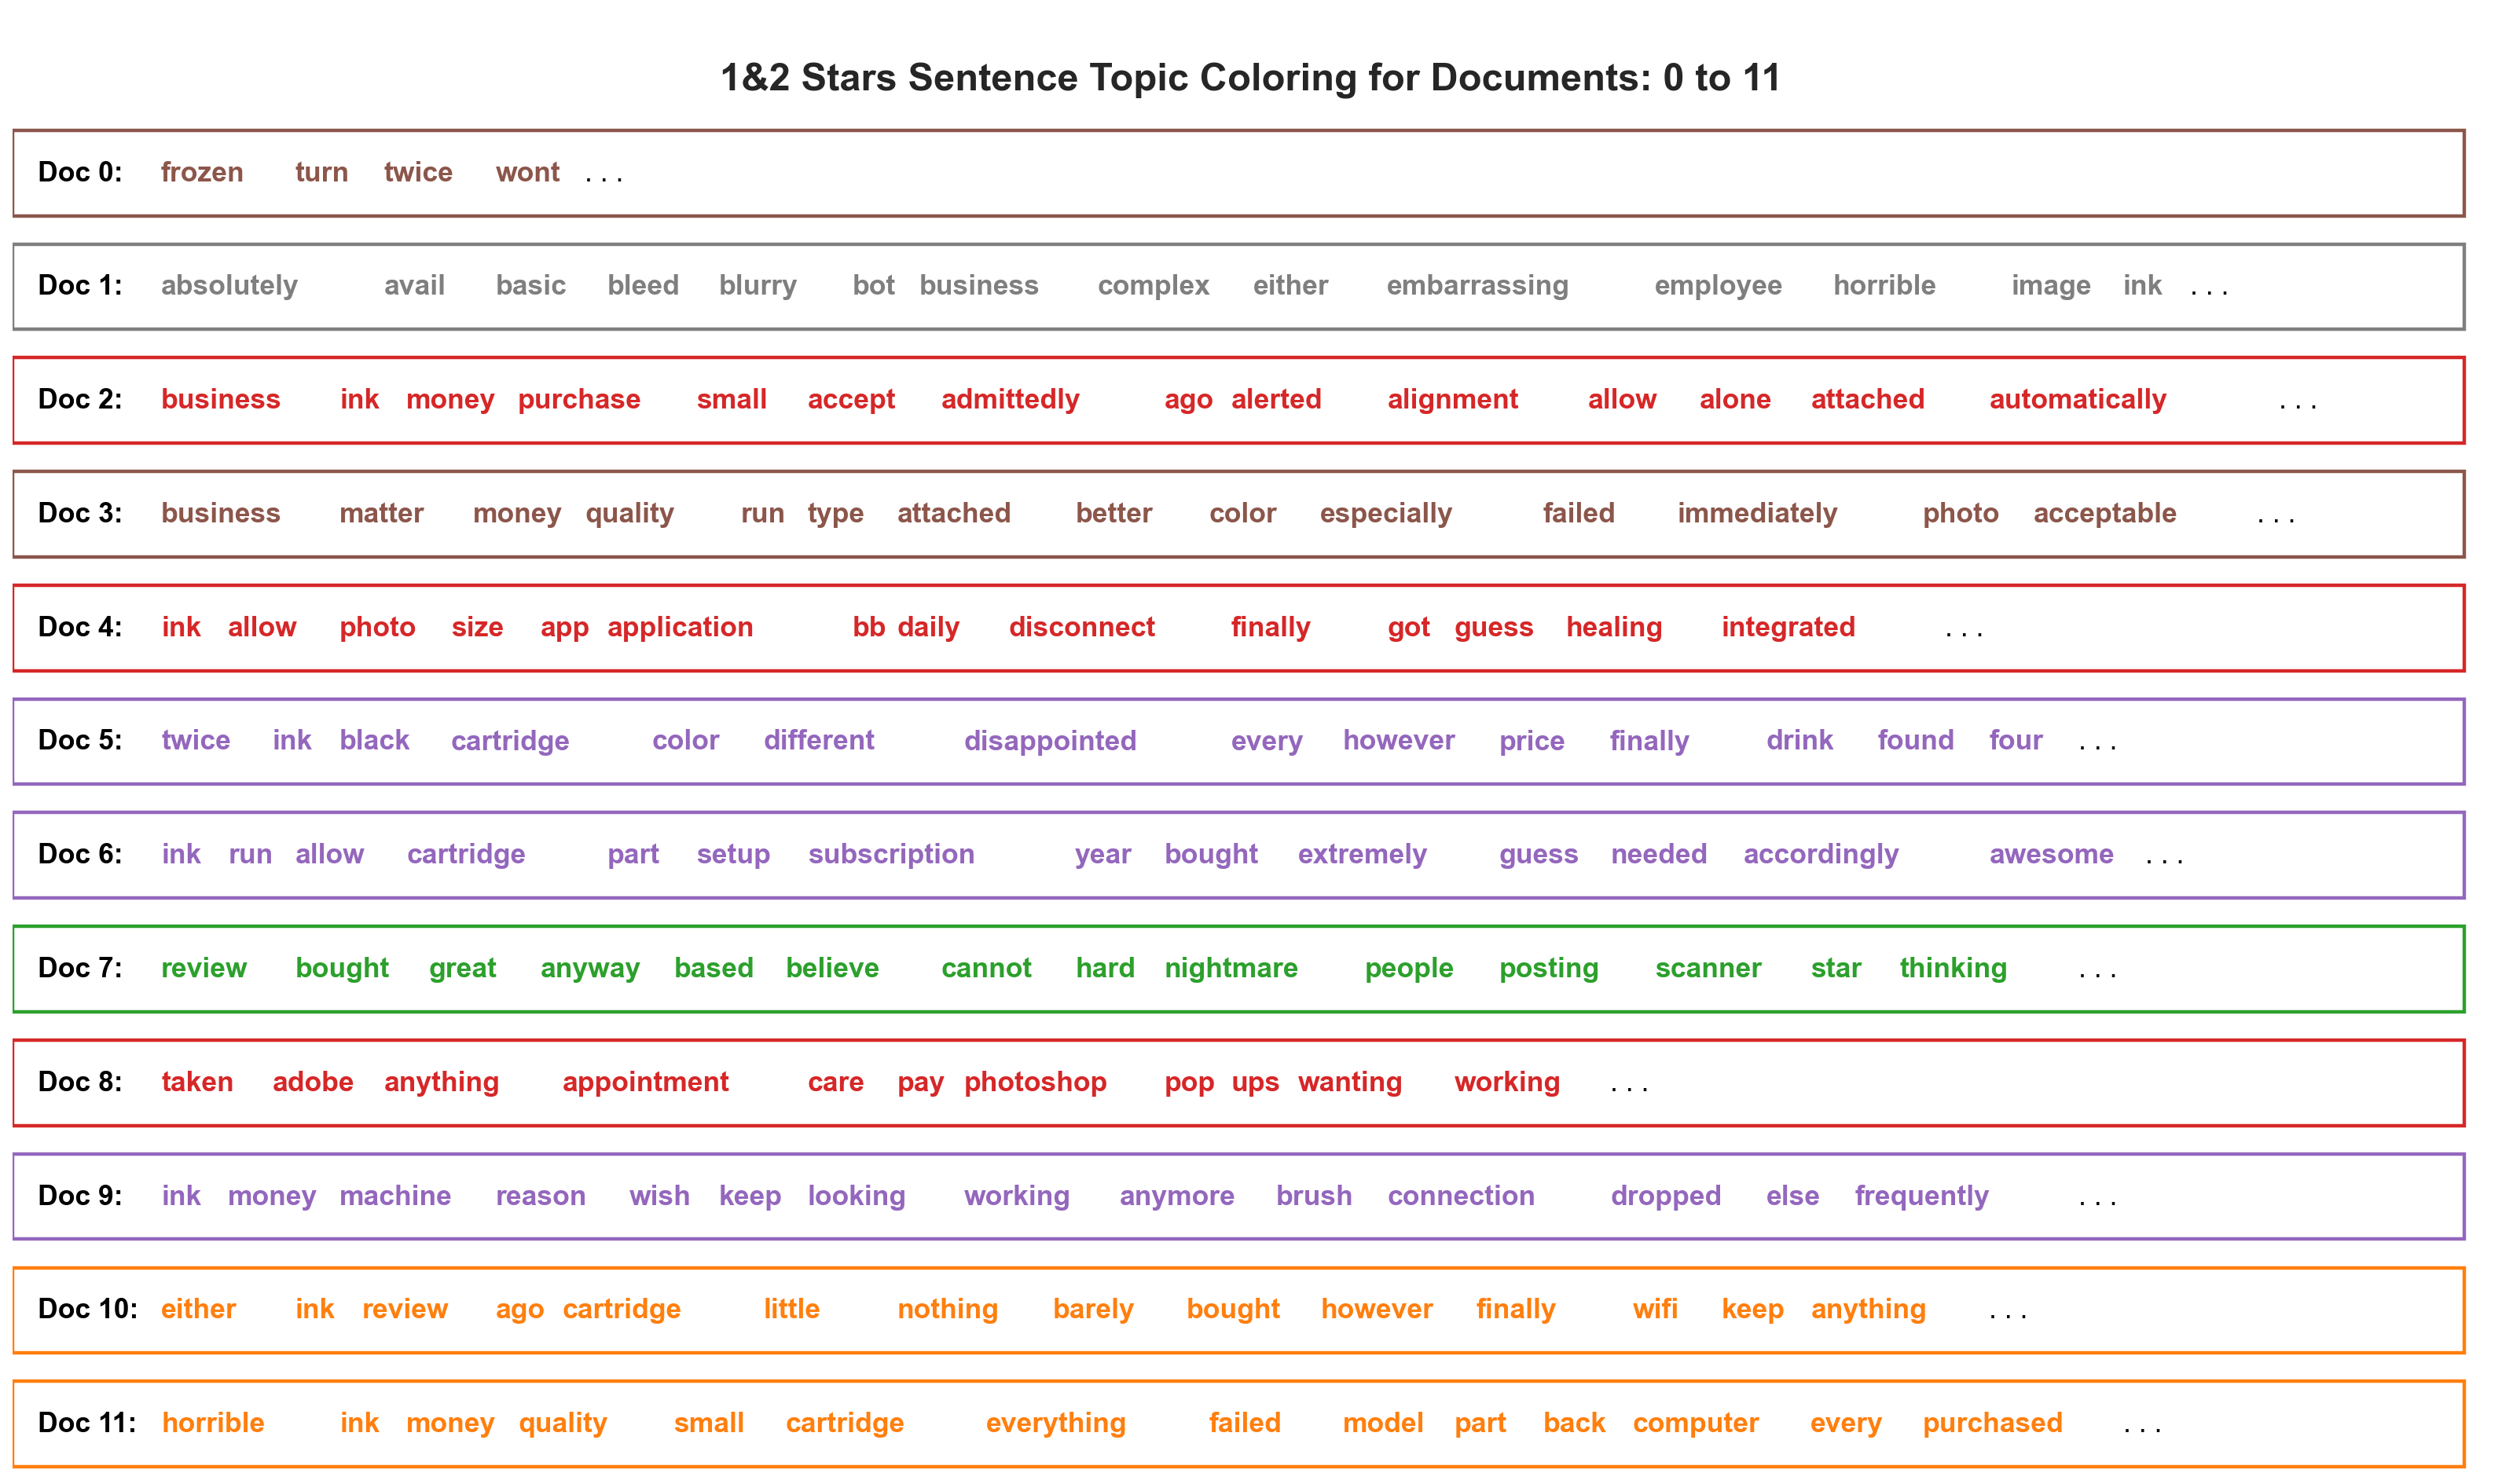

In [181]:
def sentences_chart(lda_model=lda_model_12, corpus=corpus_12, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('1&2 Stars Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.92, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

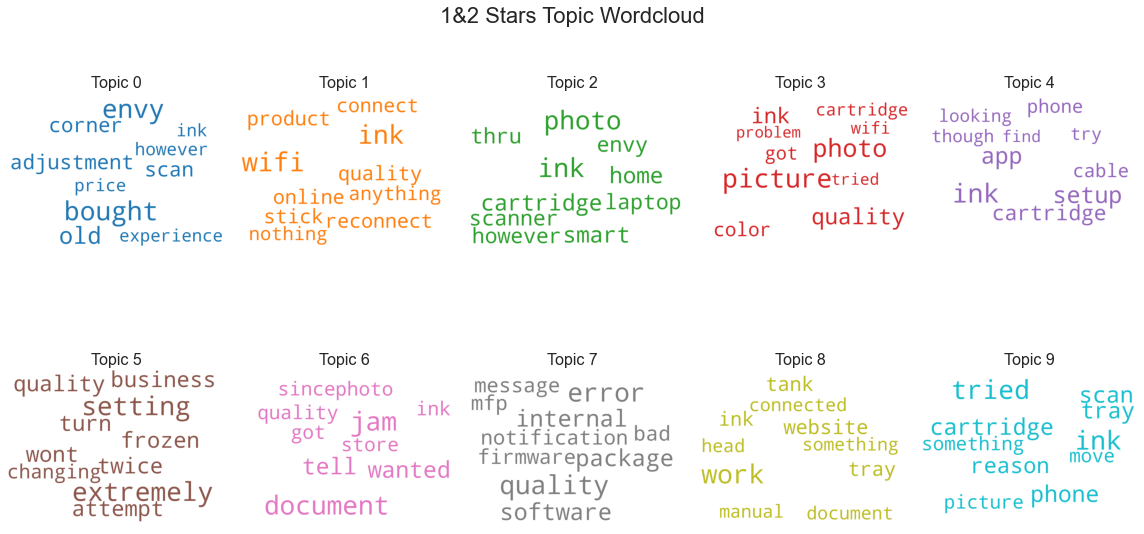

In [178]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics_12 = lda_model_12.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_12[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

fig.suptitle('1&2 Stars Topic Wordcloud', fontsize=22,y=0.9)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [175]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics_12, topic_percentages_12 = topics_per_document(model=lda_model_12, corpus=corpus_12, end=-1)            

# Distribution of Dominant Topics in Each Document
df_12 = pd.DataFrame(dominant_topics_12, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_12 = df_12.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_12 = dominant_topic_in_each_doc_12.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_12 = pd.DataFrame([dict(t) for t in topic_percentages_12])
df_topic_weightage_by_doc_12 = topic_weightage_by_doc_12.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words_12 = [(i, topic) for i, topics in lda_model_12.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked_12= pd.DataFrame(topic_top3words_12, columns=['topic_id', 'words'])
df_top3words_12= df_top3words_stacked_12.groupby('topic_id').agg(', \n'.join)
df_top3words_34.reset_index(level=0,inplace=True)

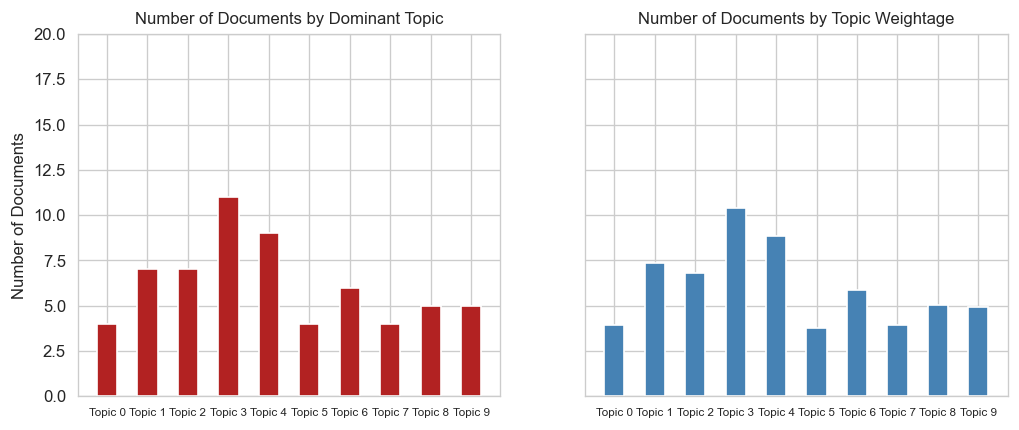

In [177]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

tick_formatter_12 = FuncFormatter(lambda x, pos: 'Topic ' + str(x))
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_12, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc_12.Dominant_Topic.unique().__len__()))
ax1.xaxis.set_major_formatter(tick_formatter_12)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 20)
ax1.xaxis.set_tick_params(labelsize=7)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_12, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_34.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter_34)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.xaxis.set_tick_params(labelsize=7)

plt.show()